-----
## Predicting Global Supply Chain Outcomes for Essential HIV Medicines using Machine Learning Methods
------

### Authors: Zhang Xiaoyang, Ang Yi Heng Bryan, Chua Shi Wei

### **Mini Project**



- ***Key Question:*** Can we use procurement transaction data to predict whether a delivery is Delayed or On-Time.
- ***Main Data Source:*** *From The Website: https://data.pepfar.net/additionalData. Procurement transaction data from the Supply Chain Management System (SCMS), administered by the United States Agency for International Development (USAID), provides information on health commodities, prices, and delivery destinations.*

### Import the relevant libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import   RandomForestClassifier
from sklearn.linear_model import  LogisticRegression
import plotly.graph_objs as go
import plotly.offline as py
from sklearn import model_selection, metrics
import yellowbrick as yb
from imblearn.over_sampling import SMOTE

### Load the data files

In [2]:
df=pd.read_excel('SCMS Data 20151023.xlsx',sheet_name=3)
# we are making a copy of data set so that the original data set is conserved
df1=df.copy()

In [3]:
df.head()

ID Project Code            PQ # PO / SO # ASN/DN #        Country  \
0   1   100-CI-T01  Pre-PQ Process    SCMS-4    ASN-8  Côte d'Ivoire   
1   3   108-VN-T01  Pre-PQ Process   SCMS-13   ASN-85        Vietnam   
2   4   100-CI-T01  Pre-PQ Process   SCMS-20   ASN-14  Côte d'Ivoire   
3  15   108-VN-T01  Pre-PQ Process   SCMS-78   ASN-50        Vietnam   
4  16   108-VN-T01  Pre-PQ Process   SCMS-81   ASN-55        Vietnam   

  Managed By  Fulfill Via Vendor INCO Term Shipment Mode  ...  \
0   PMO - US  Direct Drop              EXW           Air  ...   
1   PMO - US  Direct Drop              EXW           Air  ...   
2   PMO - US  Direct Drop              FCA           Air  ...   
3   PMO - US  Direct Drop              EXW           Air  ...   
4   PMO - US  Direct Drop              EXW           Air  ...   

  Unit of Measure (Per Pack) Line Item Quantity Line Item Value Pack Price  \
0                         30                 19           551.0      29.00   
1                        240               1000          6200.0       6.20   
2                        100                500         40000.0      80.00   
3                         60              31920        127360.8       3.99   
4                         60              38000        121600.0       3.20   

  Unit Price             Manufacturing Site First Line Designation  \
0       0.97     Ranbaxy Fine Chemicals LTD                    Yes   
1       0.03      Aurobindo Unit III, India                    Yes   
2       0.80  ABBVIE GmbH & Co.KG Wiesbaden                    Yes   
3       0.07  Ranbaxy, Paonta Shahib, India                    Yes   
4       0.05      Aurobindo Unit III, India                    Yes   

  Weight (Kilograms) Freight Cost (USD) Line Item Insurance (USD)  
0                 13             780.34                       NaN  
1                358             4521.5                       NaN  
2                171            1653.78                       NaN  
3               1855            16007.1                       NaN  
4               7590            45450.1                       NaN  

[5 rows x 33 columns]

In [4]:
df.shape #33 columns and 10324 rows

(10324, 33)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ID                            10324 non-null  int64         
 1   Project Code                  10324 non-null  object        
 2   PQ #                          10324 non-null  object        
 3   PO / SO #                     10324 non-null  object        
 4   ASN/DN #                      10324 non-null  object        
 5   Country                       10324 non-null  object        
 6   Managed By                    10324 non-null  object        
 7   Fulfill Via                   10324 non-null  object        
 8   Vendor INCO Term              10324 non-null  object        
 9   Shipment Mode                 9964 non-null   object        
 10  PQ First Sent to Client Date  10324 non-null  object        
 11  PO Sent to Vendor Date      

## Exploratory Data Analysis

In [6]:
#columns with float values 
df[['Line Item Value','Pack Price','Unit Price','Weight (Kilograms)','Freight Cost (USD)']]=df[['Line Item Value','Pack Price','Unit Price','Weight (Kilograms)','Freight Cost (USD)']].apply(pd.to_numeric,errors='coerce')



In [7]:
# columns with datetime, altough we do not need these columns as we are not going to perform the time series analysis
df[['PQ First Sent to Client Date','PO Sent to Vendor Date','Scheduled Delivery Date','Delivered to Client Date','Delivery Recorded Date']]=df[['PQ First Sent to Client Date','PO Sent to Vendor Date','Scheduled Delivery Date','Delivered to Client Date','Delivery Recorded Date']].apply(pd.to_datetime,errors='coerce')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ID                            10324 non-null  int64         
 1   Project Code                  10324 non-null  object        
 2   PQ #                          10324 non-null  object        
 3   PO / SO #                     10324 non-null  object        
 4   ASN/DN #                      10324 non-null  object        
 5   Country                       10324 non-null  object        
 6   Managed By                    10324 non-null  object        
 7   Fulfill Via                   10324 non-null  object        
 8   Vendor INCO Term              10324 non-null  object        
 9   Shipment Mode                 9964 non-null   object        
 10  PQ First Sent to Client Date  7643 non-null   datetime64[ns]
 11  PO Sent to Vendor Date      

In [9]:
df.isna().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                    360
PQ First Sent to Client Date    2681
PO Sent to Vendor Date          5732
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

In [10]:
#calculating %null values in each column
((df.isna().sum())/10324)*100

ID                               0.000000
Project Code                     0.000000
PQ #                             0.000000
PO / SO #                        0.000000
ASN/DN #                         0.000000
Country                          0.000000
Managed By                       0.000000
Fulfill Via                      0.000000
Vendor INCO Term                 0.000000
Shipment Mode                    3.487021
PQ First Sent to Client Date    25.968617
PO Sent to Vendor Date          55.521116
Scheduled Delivery Date          0.000000
Delivered to Client Date         0.000000
Delivery Recorded Date           0.000000
Product Group                    0.000000
Sub Classification               0.000000
Vendor                           0.000000
Item Description                 0.000000
Molecule/Test Type               0.000000
Brand                            0.000000
Dosage                          16.815188
Dosage Form                      0.000000
Unit of Measure (Per Pack)       0

<AxesSubplot:>

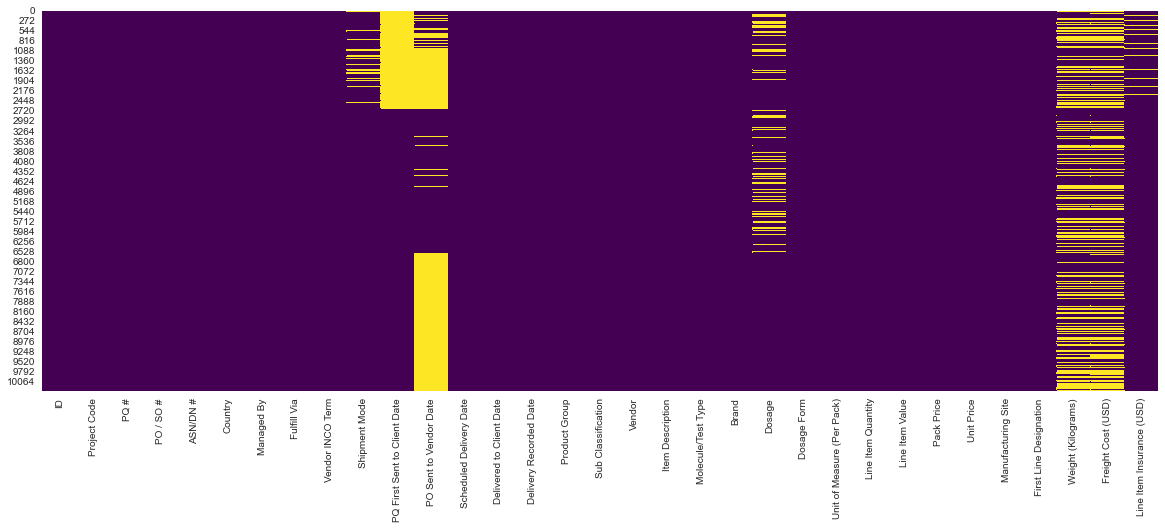

In [11]:
plt.figure(figsize=(20,7))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

Top 10 Countries Wise Count 

Vietnam          330
South Africa     282
Haiti            156
Uganda           139
Rwanda           124
Côte d'Ivoire     96
Tanzania          81
Zimbabwe          61
Ghana             32
Cameroon          32
Name: Country, dtype: int64


Text(0.5, 0, 'Country Name')

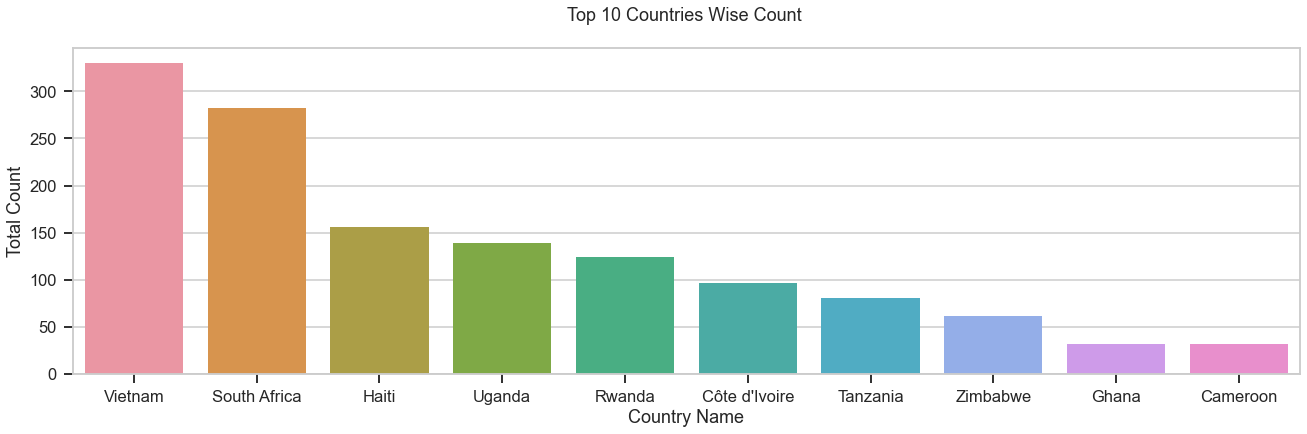

In [12]:
DataSet = df.dropna()
ItemCount = DataSet["Country"].value_counts().nlargest(10)
print("Top 10 Countries Wise Count \n")
print(ItemCount)
sns.set_context("talk",font_scale=1)
plt.figure(figsize=(22,6))
sns.countplot(DataSet['Country'],order = DataSet['Country'].value_counts().nlargest(10).index)
plt.title('Top 10 Countries Wise Count \n')
plt.ylabel('Total Count')
plt.xlabel('Country Name')

Total Pack Price for Top 15 Countries

Country
Nigeria          25620.72
South Africa     24318.90
Côte d'Ivoire    22882.35
Haiti            19521.30
Uganda           15664.08
Mozambique       14092.40
Vietnam          11963.78
Zambia           11889.67
Tanzania         11047.72
Rwanda            7724.29
Botswana          7052.54
Zimbabwe          6563.56
Kenya             6349.14
Congo, DRC        6032.41
Guyana            5659.35
Name: Pack Price, dtype: float64


Text(0.5, 0, 'Country Name')

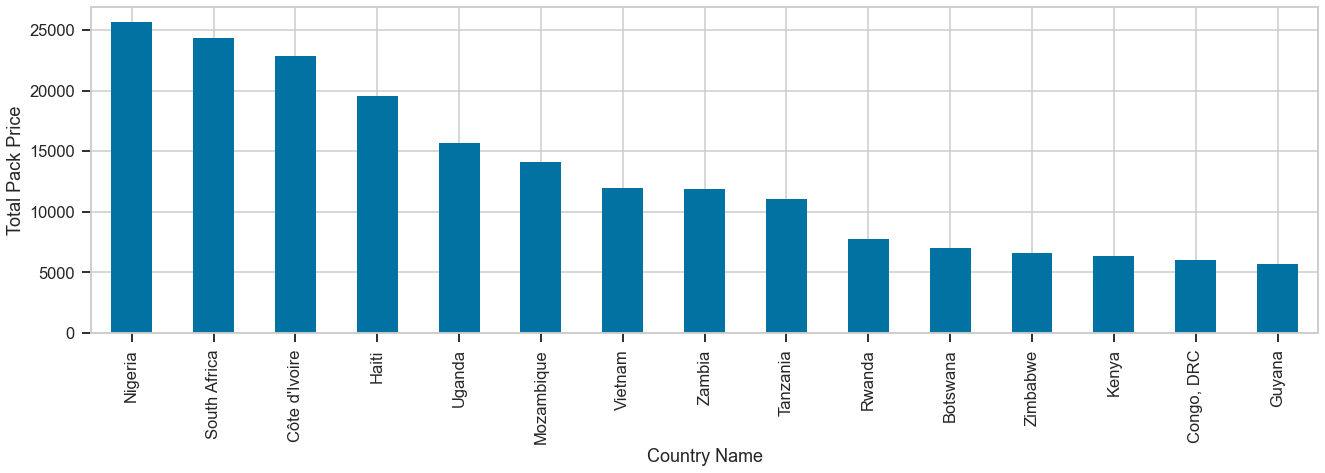

In [13]:
TotalPrice = df.groupby(['Country'])['Pack Price'].sum().nlargest(15)
print("Total Pack Price for Top 15 Countries\n")
print(TotalPrice)
plt.figure(figsize=(22,6))
GraphData=df.groupby(['Country'])['Pack Price'].sum().nlargest(15)
GraphData.plot(kind='bar')
plt.ylabel('Total Pack Price')
plt.xlabel('Country Name')

Text(0.5, 0, 'First Line Designation')

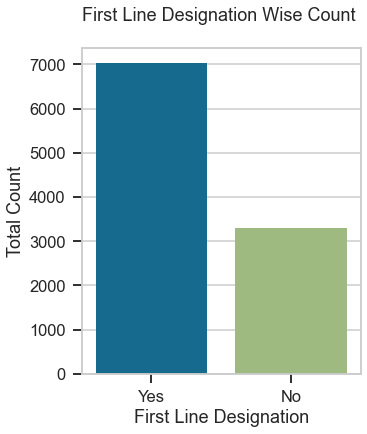

In [14]:
sns.set_context("talk",font_scale=1)
plt.figure(figsize=(5,6))
sns.countplot(df['First Line Designation'],order = df['First Line Designation'].value_counts().nlargest(10).index)
plt.title('First Line Designation Wise Count \n')
plt.ylabel('Total Count')
plt.xlabel('First Line Designation')

In [15]:
ShippingMode = df["Shipment Mode"].value_counts()
labels = (np.array(ShippingMode.index))
sizes = (np.array((ShippingMode / ShippingMode.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title="Shipment Mode")
dat = [trace]
fig = go.Figure(data=dat, layout=layout)
py.iplot(fig, filename="Shipment Mode")

In [16]:
UniqueItem = DataSet['Manufacturing Site'].unique()
print("All Unique Manufacturing Site \n")
print(UniqueItem)

All Unique Manufacturing Site 

['Mylan (formerly Matrix) Nashik' 'Cipla, Goa, India'
 'ABBVIE Ludwigshafen Germany' 'Hetero Unit III Hyderabad IN'
 'Aurobindo Unit III, India' 'ABBVIE (Abbott) Logis. UK'
 'Janssen-Cilag, Latina, IT' 'Aurobindo Unit VII, IN'
 'Micro labs, Verna, Goa, India' 'Mylan,  H-12 & H-13, India'
 'Hetero, Jadcherla, unit 5, IN' 'Strides, Bangalore, India.'
 'Novartis Pharma Suffern, USA' 'Roche Madrid' 'BMS Meymac, France'
 'Bristol-Myers Squibb Anagni IT' 'MSD, Haarlem, NL'
 'Medochemie Factory A, CY' 'Cipla Ltd A-42 MIDC Mahar. IN' 'Roche Basel'
 'Emcure Plot No.P-2, I.T-B.T. Park, Phase II, MIDC, Hinjwadi, Pune, India'
 'GSK Mississauga (Canada)' 'Aspen-OSD, Port Elizabeth, SA'
 'Gilead(Nycomed) Oranienburg DE' 'Micro Labs Ltd. (Brown & Burk), India'
 'Micro Labs, Hosur, India' 'Cipla, Patalganga, India'
 'Remedica, Limassol, Cyprus' 'Guilin OSD site, No 17, China'
 'Cipla, Kurkumbh, India' 'GSK Barnard Castle UK'
 "ABBVIE (Abbott) St. P'burg USA" 'Janssen Or

In [17]:
ItemData=df[df['Shipment Mode']=='Air']
print ("The Max Air Shipment Mode is :",ItemData['Unit of Measure (Per Pack)'].max())
print ("The Min Air Shipment is :",ItemData['Unit of Measure (Per Pack)'].min())
ItemTypeMean = ItemData['Unit of Measure (Per Pack)'].mean()
print ("The Mean Air Shipment is :", round(ItemTypeMean,2))

The Max Air Shipment Mode is : 1000
The Min Air Shipment is : 1
The Mean Air Shipment is : 82.34


Manufacturing Site
Aurobindo Unit III, India                                                   421
Mylan (formerly Matrix) Nashik                                              212
ABBVIE Ludwigshafen Germany                                                 170
Hetero Unit III Hyderabad IN                                                158
Cipla, Goa, India                                                           105
ABBVIE (Abbott) Logis. UK                                                   103
Strides, Bangalore, India.                                                   76
MSD, Haarlem, NL                                                             39
Emcure Plot No.P-2, I.T-B.T. Park, Phase II, MIDC, Hinjwadi, Pune, India     31
Micro labs, Verna, Goa, India                                                24
dtype: int64


Text(0.5, 0, 'Manufacturing Site Name')

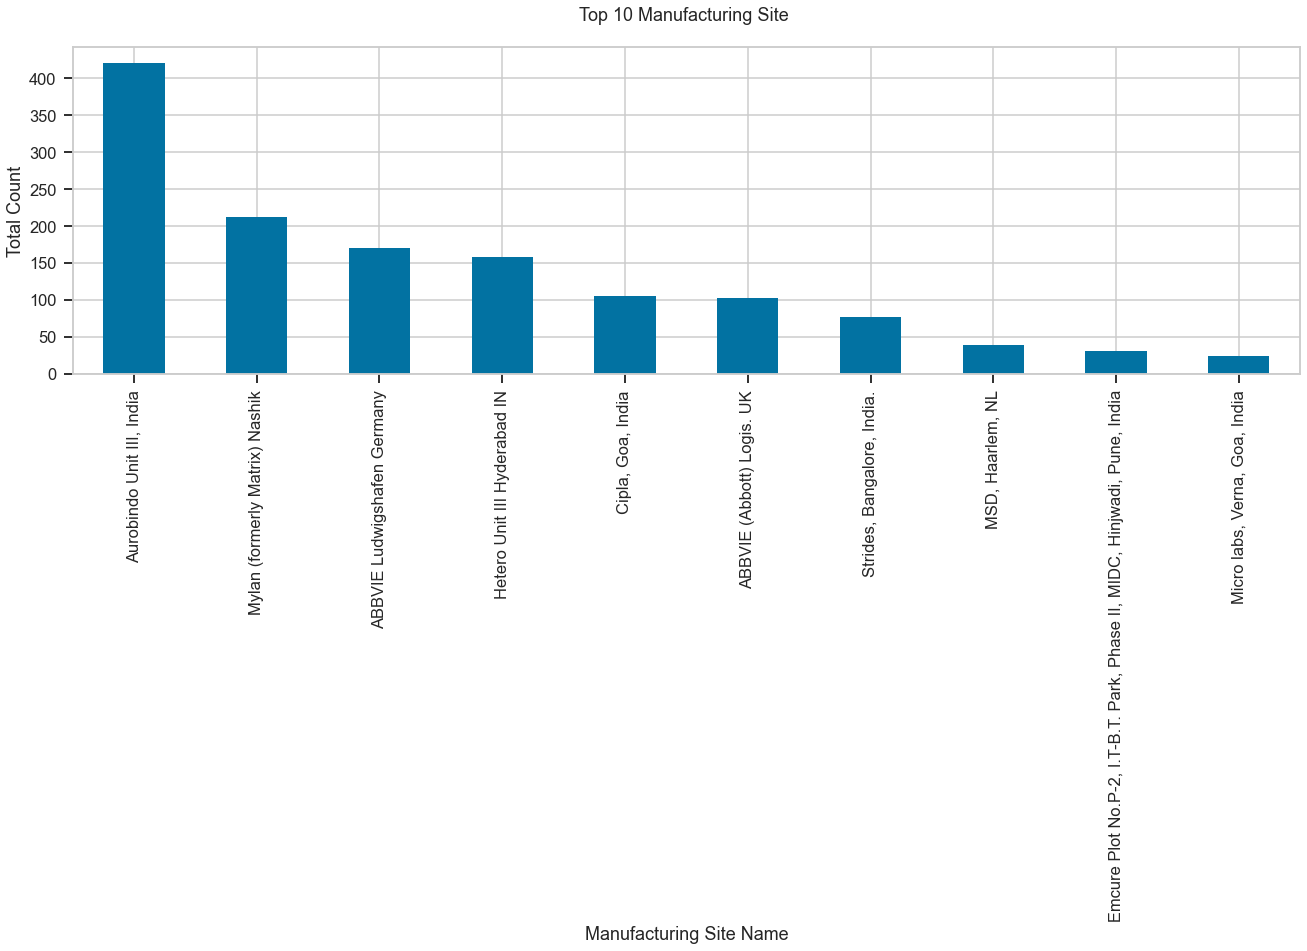

In [18]:
plt.figure(figsize=(22,6))
TopFiveManufacturingSite=DataSet.groupby('Manufacturing Site').size().nlargest(10)
print(TopFiveManufacturingSite)
TopFiveManufacturingSite.plot(kind='bar')
plt.title('Top 10 Manufacturing Site \n')
plt.ylabel('Total Count')
plt.xlabel('Manufacturing Site Name')

Top 10 Air Manufacturing Site 

Aurobindo Unit III, India         1694
Mylan (formerly Matrix) Nashik     695
Alere Medical Co., Ltd.            473
Hetero Unit III Hyderabad IN       417
Trinity Biotech, Plc               383
Inverness Japan                    320
ABBVIE Ludwigshafen Germany        285
Cipla, Goa, India                  274
Strides, Bangalore, India.         256
ABBVIE (Abbott) Logis. UK          150
Name: Manufacturing Site, dtype: int64


Text(0.5, 0, 'Manufacturing Site')

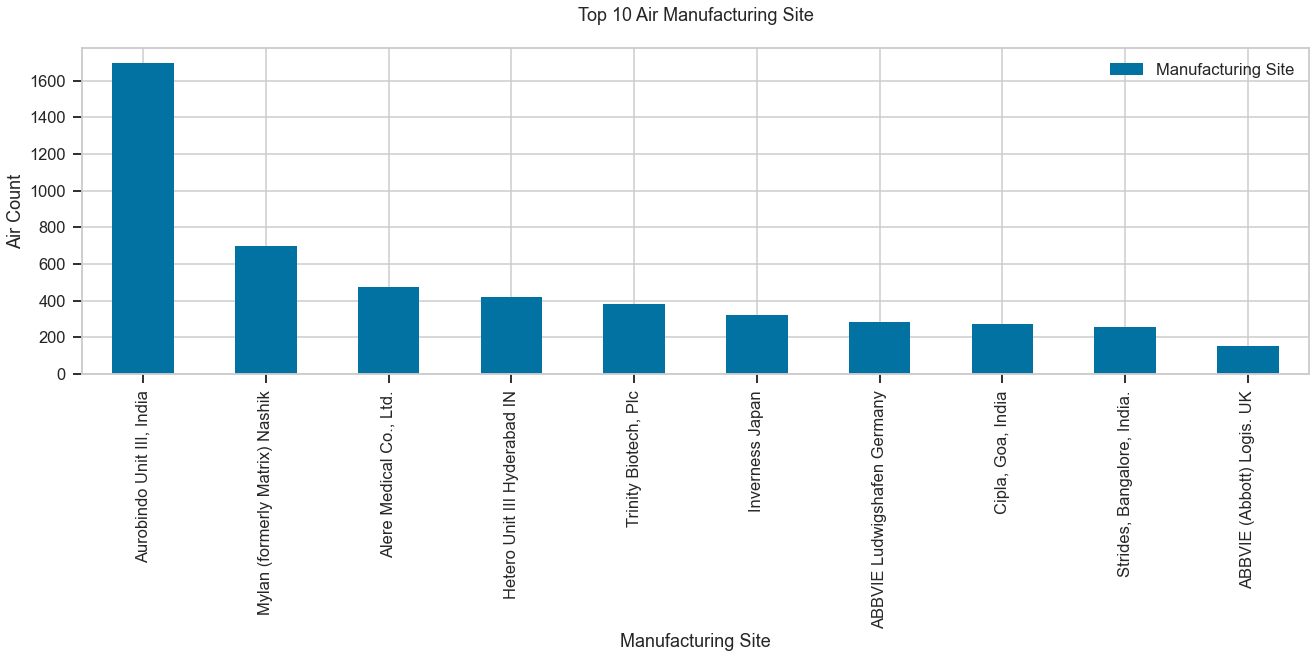

In [19]:
# Top 10 Air Shipment Mode in Bar Chart
ItemData=df[df['Shipment Mode']=='Air']
df[df["Shipment Mode"]=='Air']['Manufacturing Site'].value_counts()[0:10].to_frame().plot.bar(figsize=(22,6))
ItemSupplier = df[df["Shipment Mode"]=='Air']['Manufacturing Site'].value_counts()[0:10]
print("Top 10 Air Manufacturing Site \n")
print(ItemSupplier)
plt.title('Top 10 Air Manufacturing Site\n')
plt.ylabel('Air Count')
plt.xlabel('Manufacturing Site')

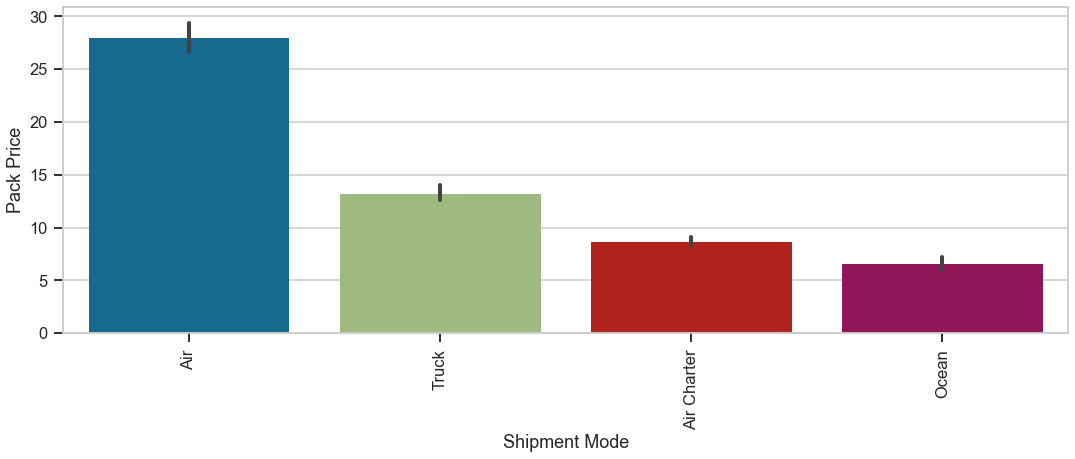

In [20]:
plt.subplots(figsize = (18,6))
plt.xticks(rotation = 90)
sns.barplot('Shipment Mode','Pack Price', data = df)
plt.show()

# Conclusion

* Top Country for Pack Price : Nigeria - 25,620.72
* Top Shipping Mode : Air
* The Max Air Shipment Mode is : 1000
* The Min Air Shipment is : 1
* The Mean Air Shipment is : 82.35
* Top Manufacturing Site : Aurobindo Unit III, India - 3172
* Top Air Manufacturing Site : Aurobindo Unit III, India - 1694

In [21]:
numerical_columns=[]
for column in df.columns:
    if (df[column].dtype=='int64') or (df[column].dtype=='float64'):
        numerical_columns.append(column)

In [22]:
numerical_columns

['ID',
 'Unit of Measure (Per Pack)',
 'Line Item Quantity',
 'Line Item Value',
 'Pack Price',
 'Unit Price',
 'Weight (Kilograms)',
 'Freight Cost (USD)',
 'Line Item Insurance (USD)']

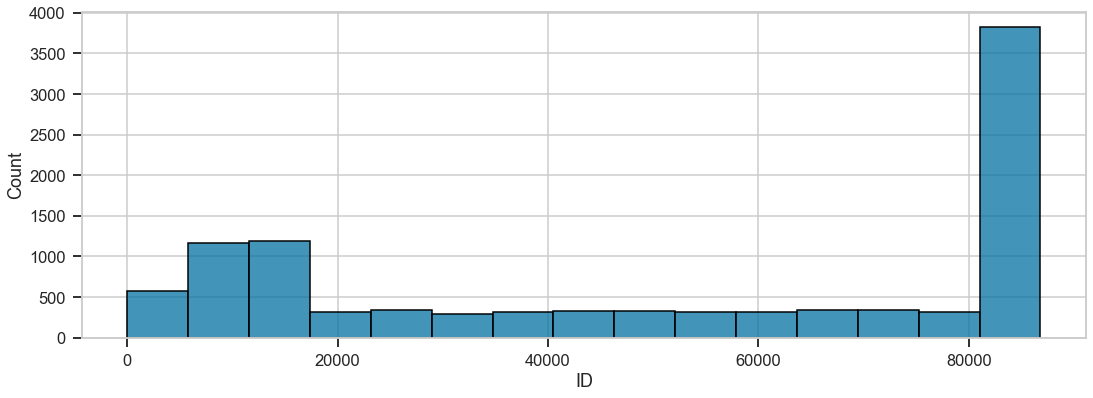

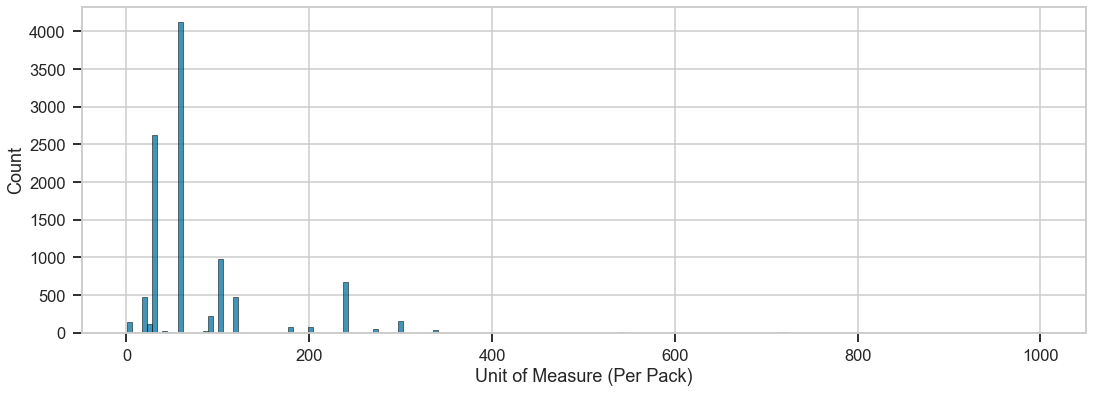

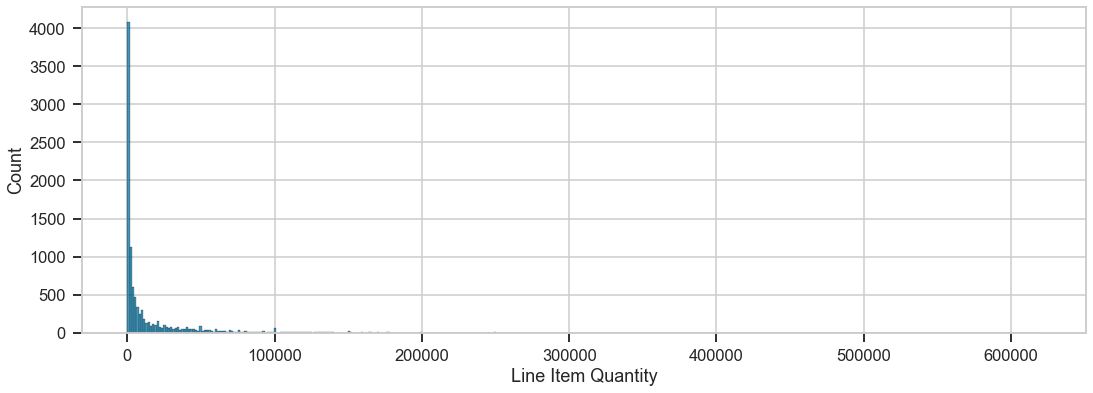

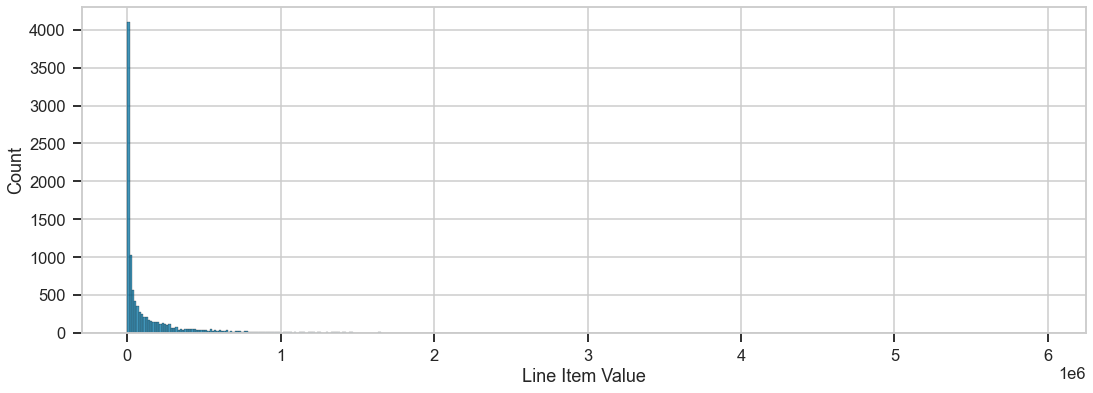

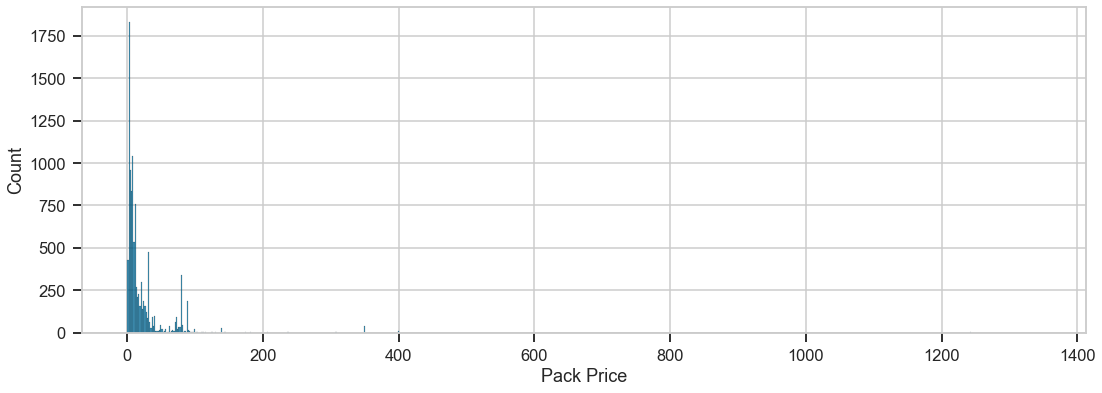

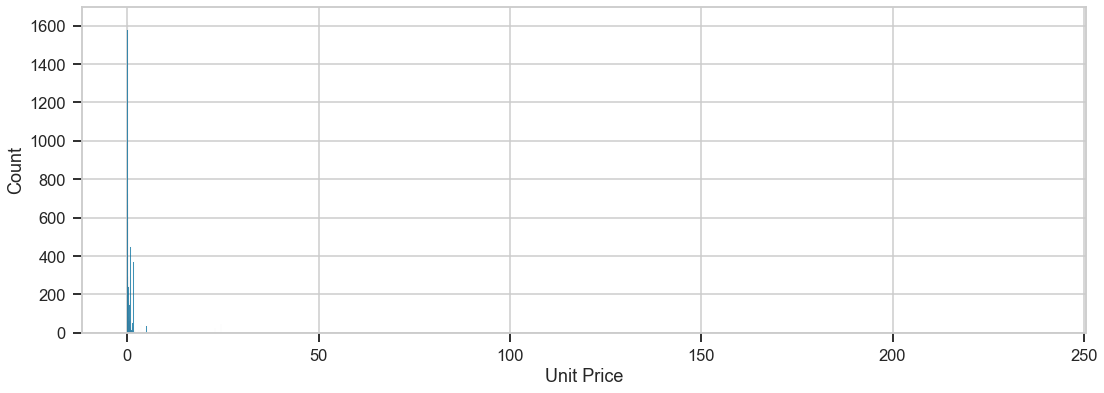

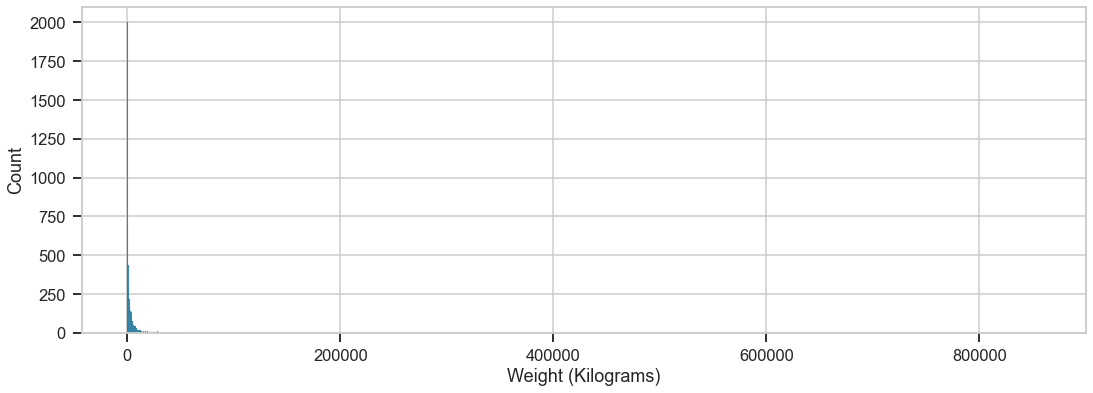

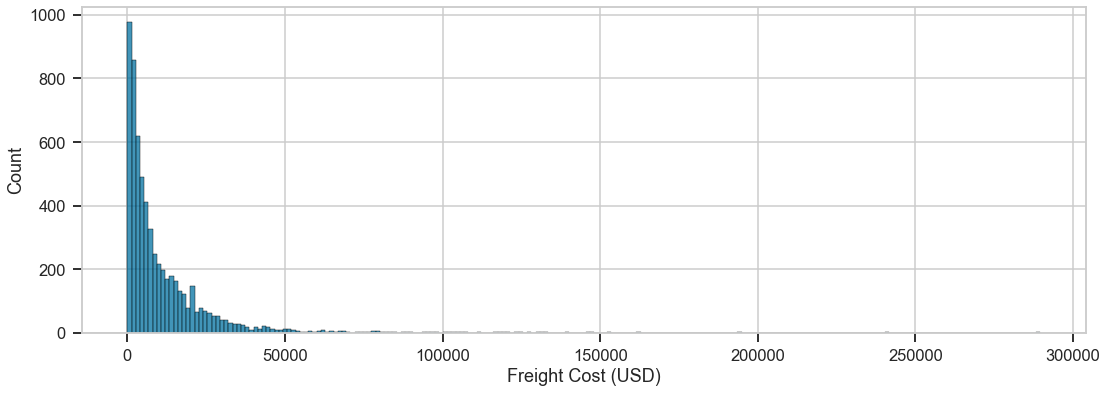

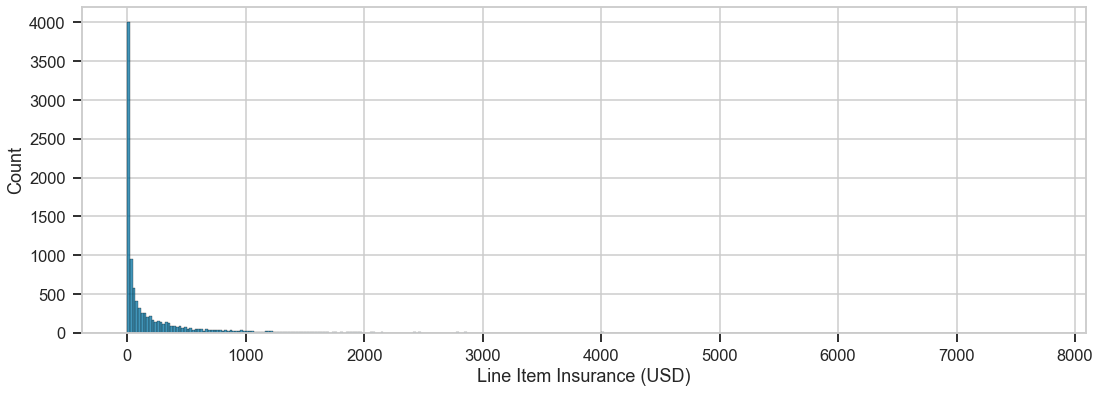

In [23]:

for column in numerical_columns:
    plt.subplots(figsize = (18,6))
    sns.histplot(df[column])
    plt.show()

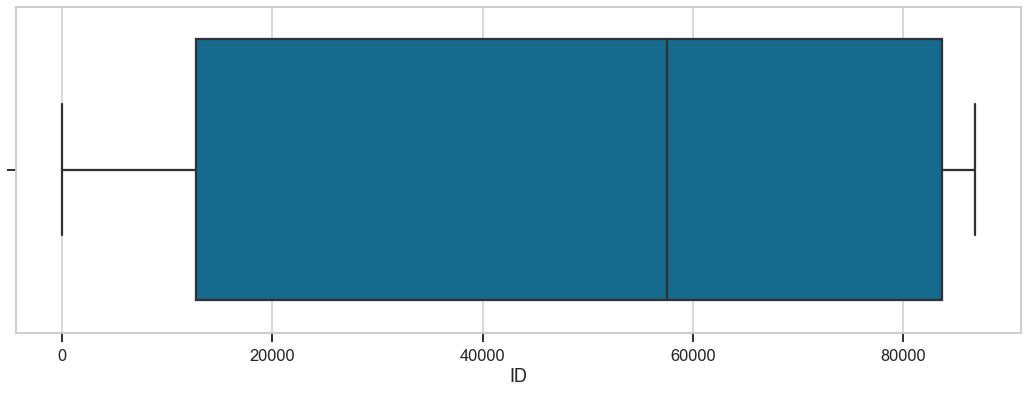

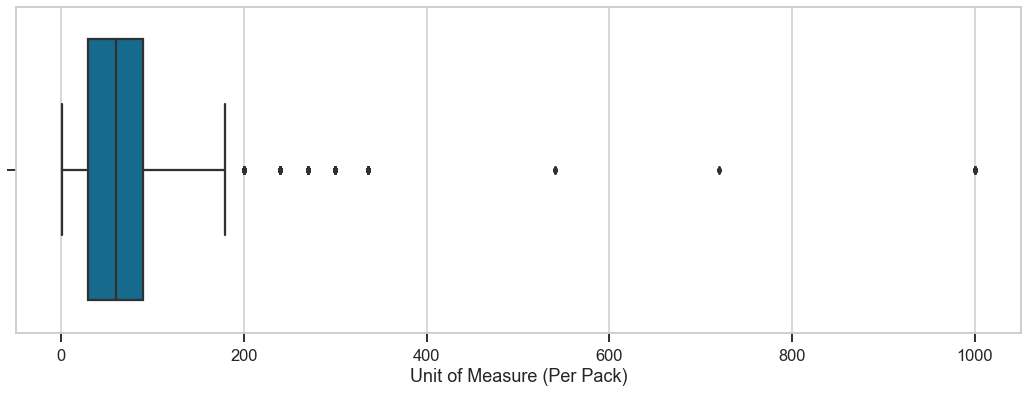

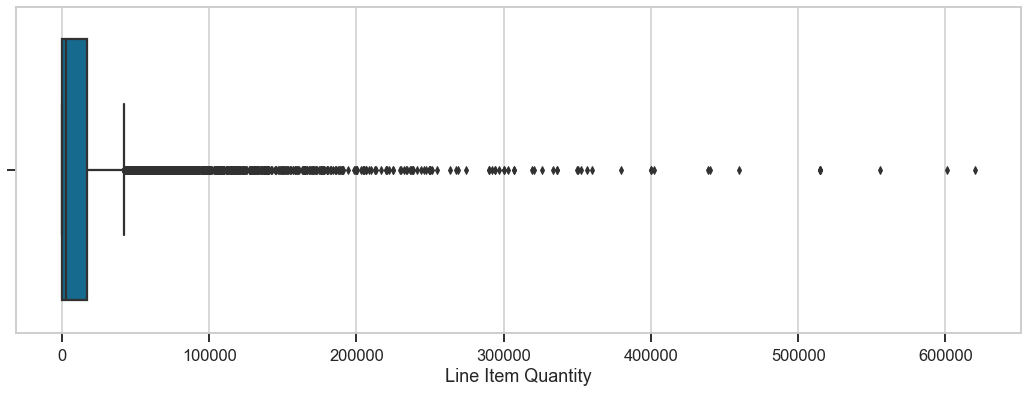

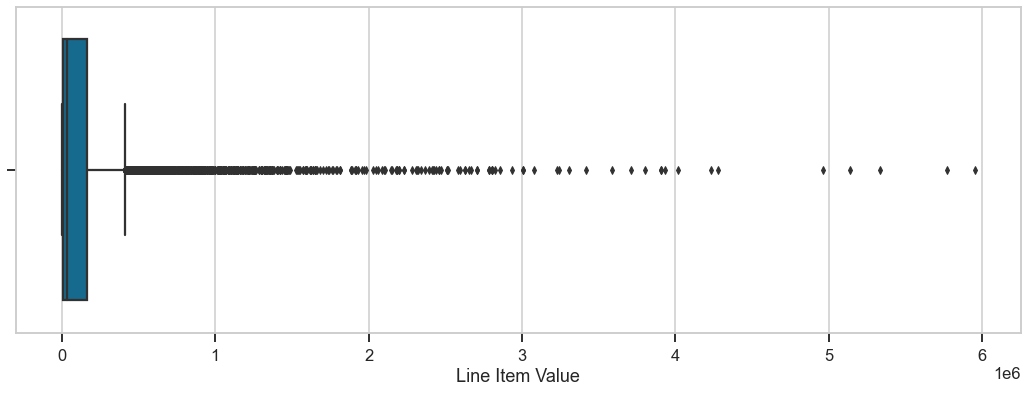

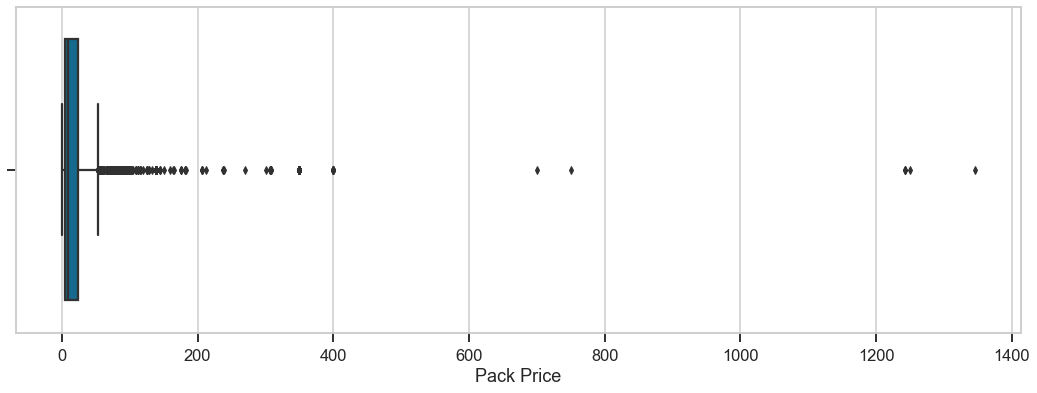

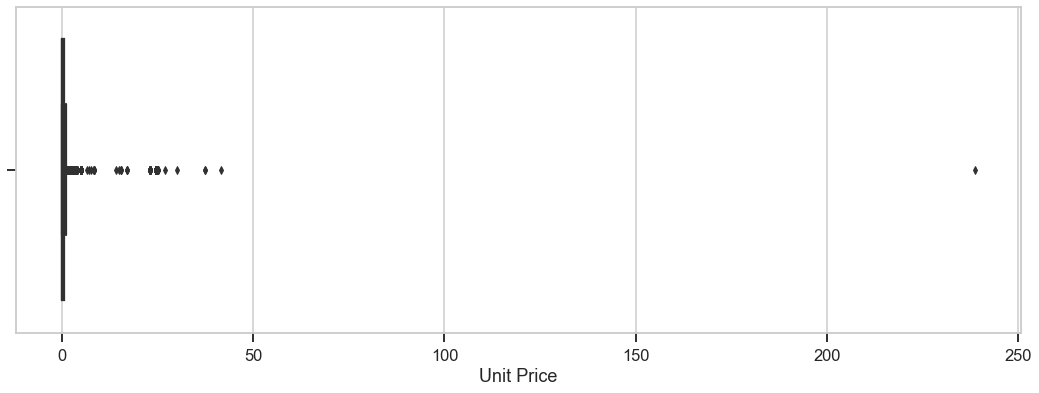

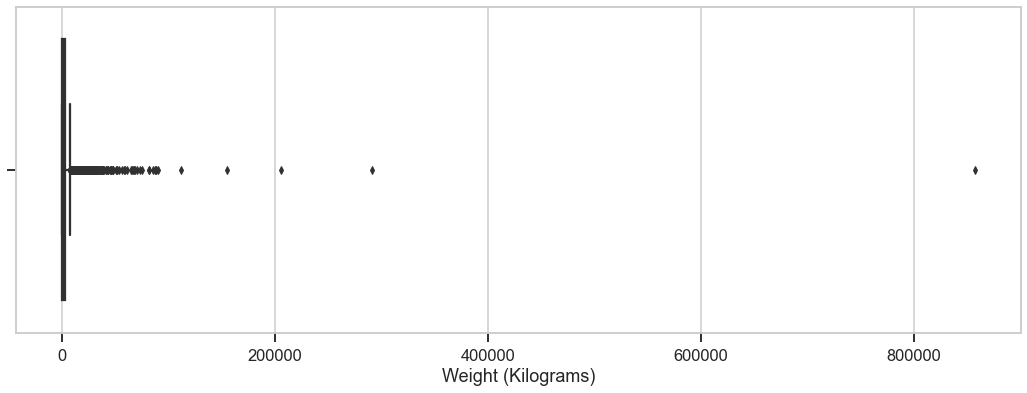

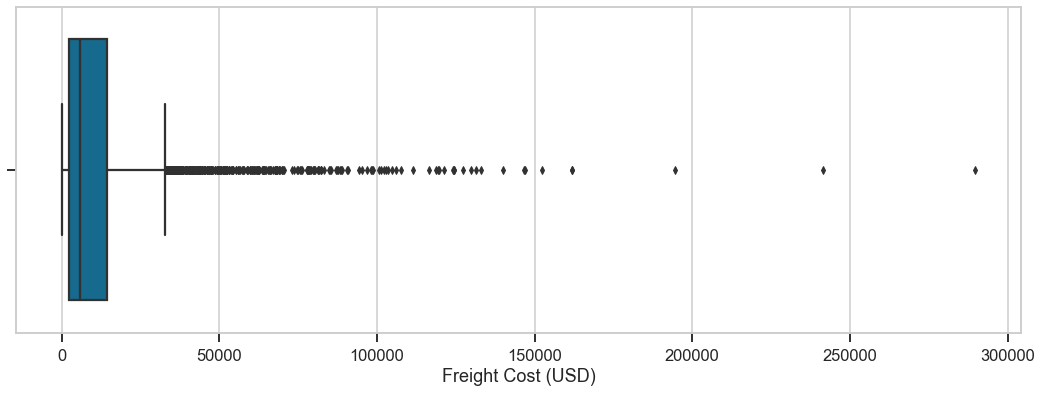

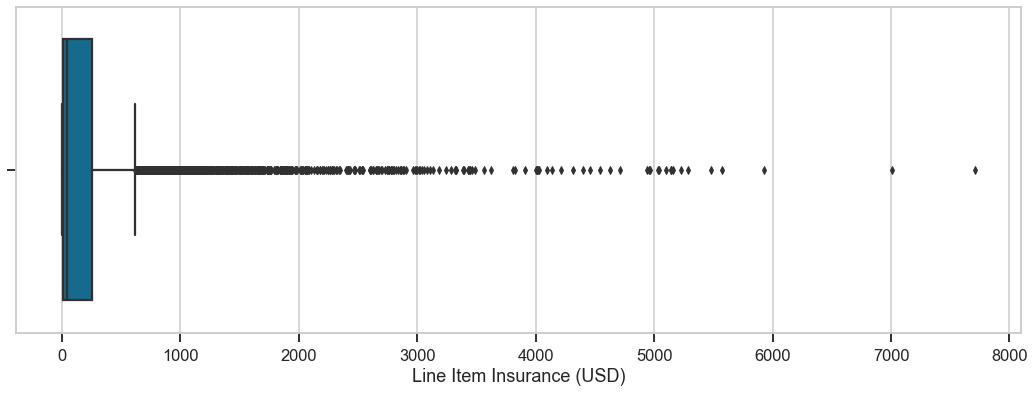

In [24]:
for column in numerical_columns:
    plt.subplots(figsize = (18,6))
    sns.boxplot(df[column])
    plt.xlabel(column)
    plt.show()

#### OHH!! Too many outliers, will get back to them during the cleaning phase

In [25]:
df.corr()

ID  Unit of Measure (Per Pack)  \
ID                          1.000000                   -0.083356   
Unit of Measure (Per Pack) -0.083356                    1.000000   
Line Item Quantity          0.192006                   -0.151020   
Line Item Value             0.136335                   -0.128666   
Pack Price                 -0.168745                    0.097182   
Unit Price                 -0.073268                   -0.102806   
Weight (Kilograms)          0.072351                   -0.034078   
Freight Cost (USD)          0.107974                   -0.053904   
Line Item Insurance (USD)   0.103557                   -0.131825   

                            Line Item Quantity  Line Item Value  Pack Price  \
ID                                    0.192006         0.136335   -0.168745   
Unit of Measure (Per Pack)           -0.151020        -0.128666    0.097182   
Line Item Quantity                    1.000000         0.839081   -0.133651   
Line Item Value                       0.839081         1.000000   -0.018809   
Pack Price                           -0.133651        -0.018809    1.000000   
Unit Price                           -0.052227        -0.019583    0.250043   
Weight (Kilograms)                    0.355840         0.351372   -0.041042   
Freight Cost (USD)                    0.378289         0.429676   -0.017971   
Line Item Insurance (USD)             0.798662         0.961353   -0.015398   

                            Unit Price  Weight (Kilograms)  \
ID                           -0.073268            0.072351   
Unit of Measure (Per Pack)   -0.102806           -0.034078   
Line Item Quantity           -0.052227            0.355840   
Line Item Value              -0.019583            0.351372   
Pack Price                    0.250043           -0.041042   
Unit Price                    1.000000           -0.014297   
Weight (Kilograms)           -0.014297            1.000000   
Freight Cost (USD)            0.082832            0.232052   
Line Item Insurance (USD)    -0.021433            0.617192   

                            Freight Cost (USD)  Line Item Insurance (USD)  
ID                                    0.107974                   0.103557  
Unit of Measure (Per Pack)           -0.053904                  -0.131825  
Line Item Quantity                    0.378289                   0.798662  
Line Item Value                       0.429676                   0.961353  
Pack Price                           -0.017971                  -0.015398  
Unit Price                            0.082832                  -0.021433  
Weight (Kilograms)                    0.232052                   0.617192  
Freight Cost (USD)                    1.000000                   0.377987  
Line Item Insurance (USD)             0.377987                   1.000000

### we can observe that the correlation of 'Weight (Kilograms)','Line Item Quantity','Pack Price' and 'Line Item Insurance (USD)  is strong with the target variable 'Freight Cost (USD)' 

# Let's move to  the categorical variables

In [26]:
# we say that if the no. of classes is less than 10 then the column is a categorical column
categorical_columns=[]
for column in df.columns:
    if(len(df[column].unique())<10):
        categorical_columns.append(column)
    else:
        continue

In [27]:
print('No. of unique categories in every column\n')
for i in categorical_columns:
    print(i,':',len(df[i].unique()),'\n')
    

No. of unique categories in every column

Managed By : 4 

Fulfill Via : 2 

Vendor INCO Term : 8 

Shipment Mode : 5 

Product Group : 5 

Sub Classification : 6 

First Line Designation : 2 



Feature name: Managed By  
 unique elements of this column are ['PMO - US' 'South Africa Field Office' 'Haiti Field Office'
 'Ethiopia Field Office']


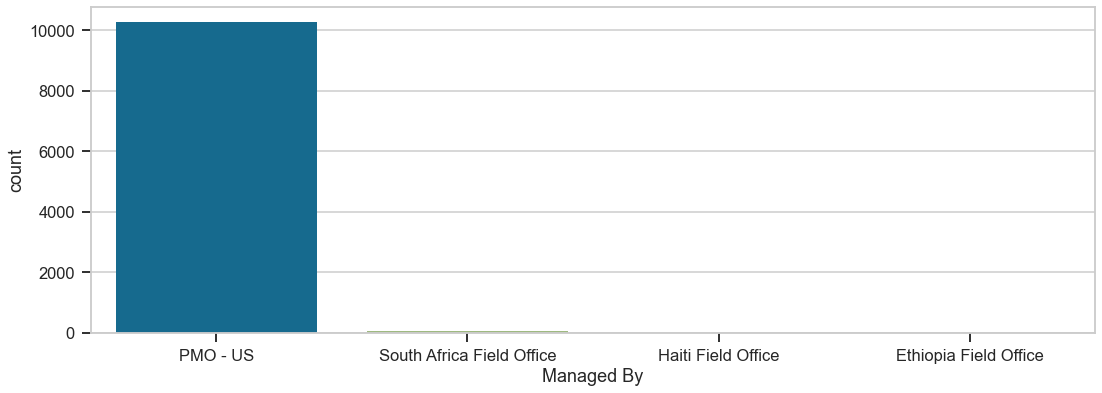





Feature name: Fulfill Via  
 unique elements of this column are ['Direct Drop' 'From RDC']


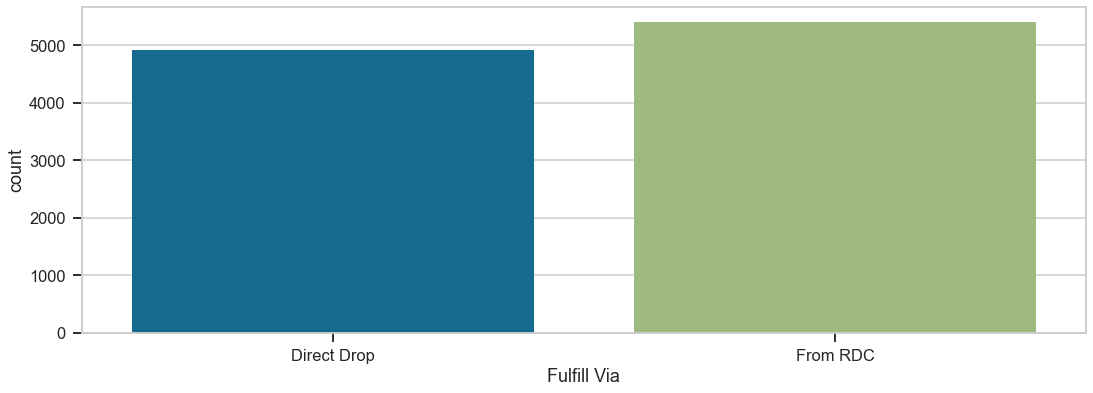





Feature name: Vendor INCO Term  
 unique elements of this column are ['EXW' 'FCA' 'DDU' 'CIP' 'DDP' 'CIF' 'N/A - From RDC' 'DAP']


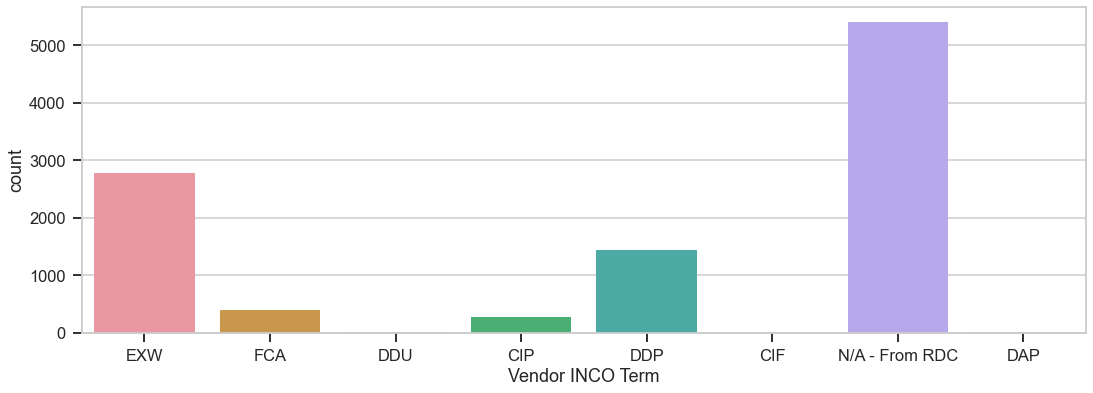





Feature name: Shipment Mode  
 unique elements of this column are ['Air' nan 'Truck' 'Air Charter' 'Ocean']


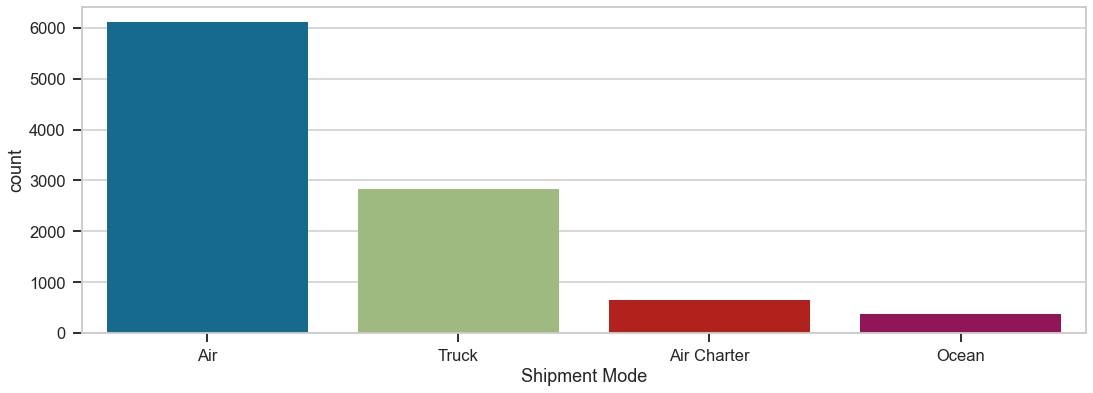





Feature name: Product Group  
 unique elements of this column are ['HRDT' 'ARV' 'ACT' 'MRDT' 'ANTM']


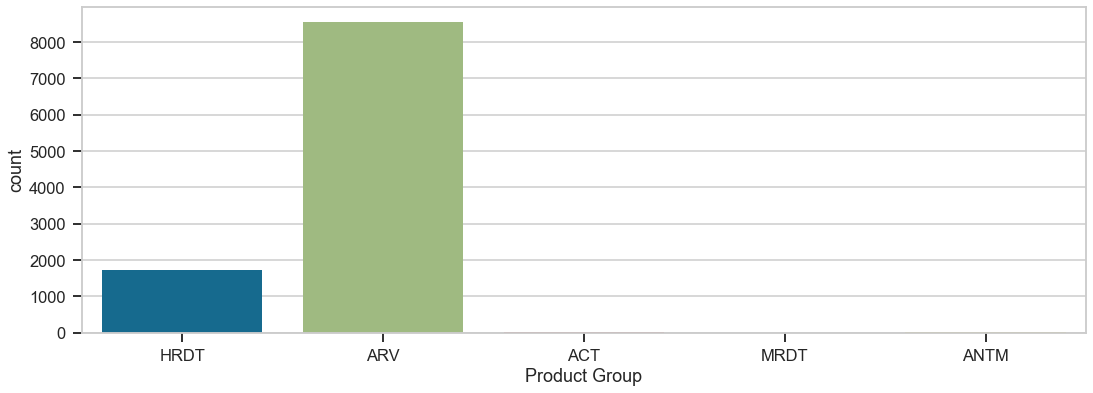





Feature name: Sub Classification  
 unique elements of this column are ['HIV test' 'Pediatric' 'Adult' 'HIV test - Ancillary' 'ACT' 'Malaria']


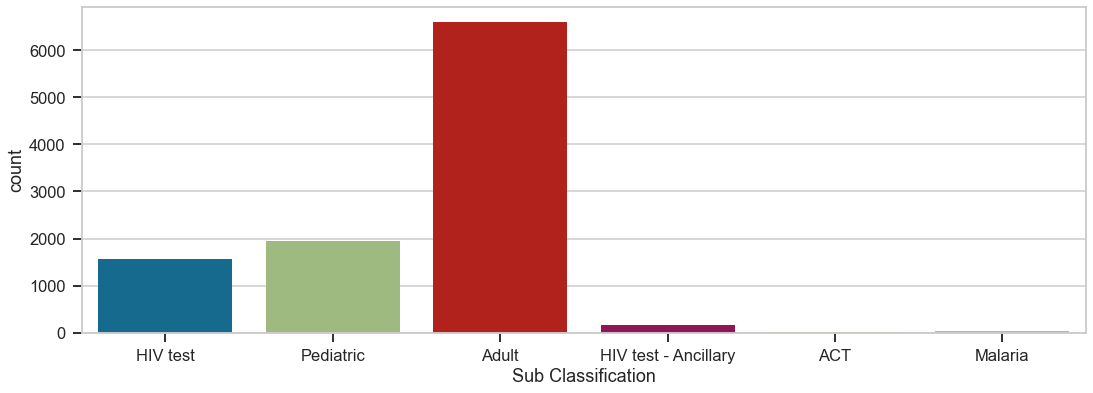





Feature name: First Line Designation  
 unique elements of this column are ['Yes' 'No']


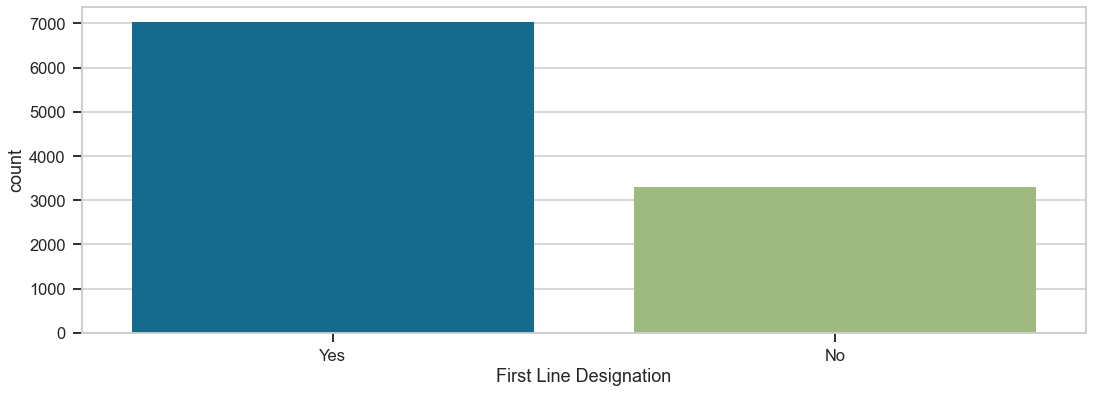

In [28]:
import warnings
warnings.filterwarnings('ignore')
for i  in categorical_columns:
        plt.subplots(figsize = (18,6))
        print('Feature name:',i,' \n unique elements of this column are',df[i].unique())
        sns.countplot(df[i])
        plt.xlabel(i)
        plt.ylabel('count')
        plt.show()
        print('\n\n\n')

### lets's look at the avg. frieght cost for each category of categorical columns

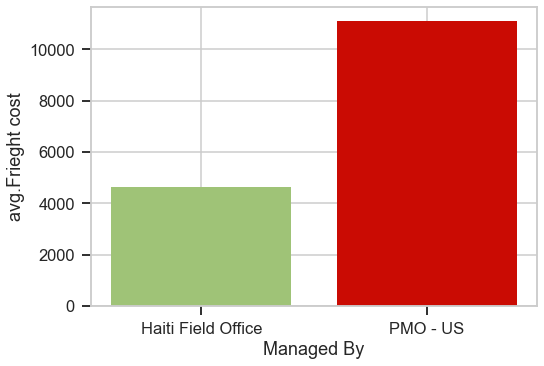

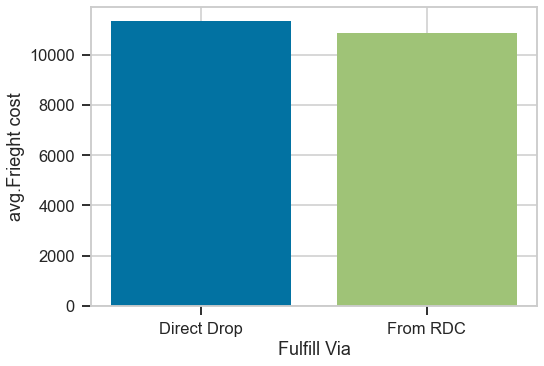

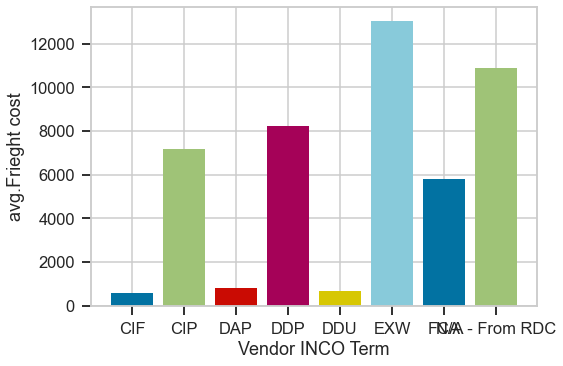

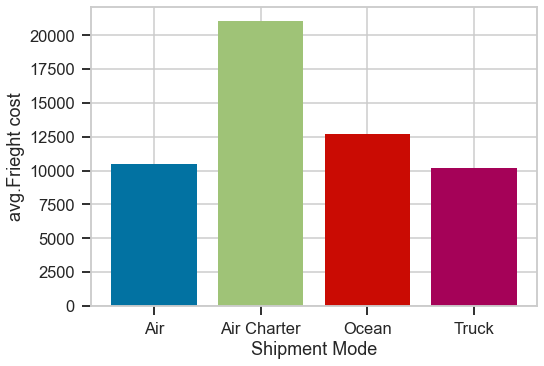

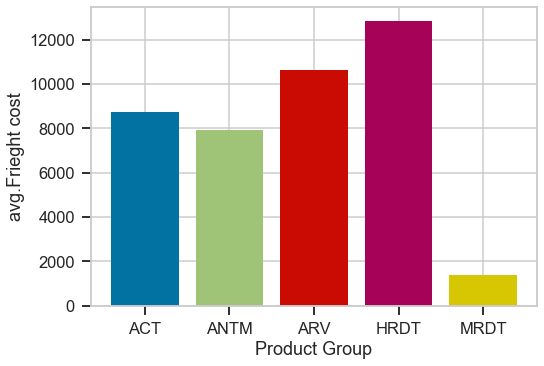

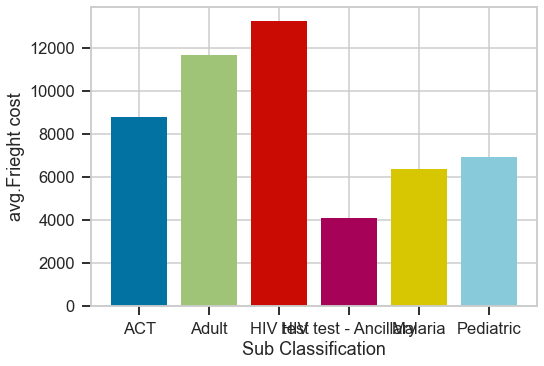

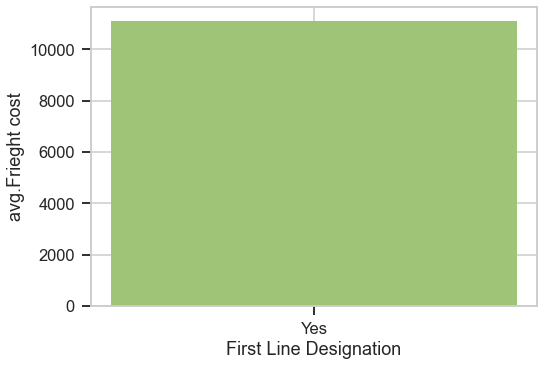

In [29]:
for column in categorical_columns:
    g=df.groupby(column)
    for name,df1 in g:
        
        plt.bar(name,df1['Freight Cost (USD)'].mean())
        plt.ylabel('avg.Frieght cost')
    plt.xlabel(column)
    plt.show()


### Oh! why the last bar graph giving only one bar?
### that means the frieght cost is not defined where 'First Line Designation' is categorised as 'No', let's see

In [30]:
g=df.groupby('First Line Designation')
for name,df1 in g:
    if name=='No':
        print(df1['Freight Cost (USD)'])

8       NaN
48      NaN
57      NaN
78      NaN
79      NaN
         ..
10318   NaN
10319   NaN
10320   NaN
10321   NaN
10323   NaN
Name: Freight Cost (USD), Length: 3294, dtype: float64


### we can see that all are Nan values, So there is no meaning of having this column
### we will  delete it in cleaning phase

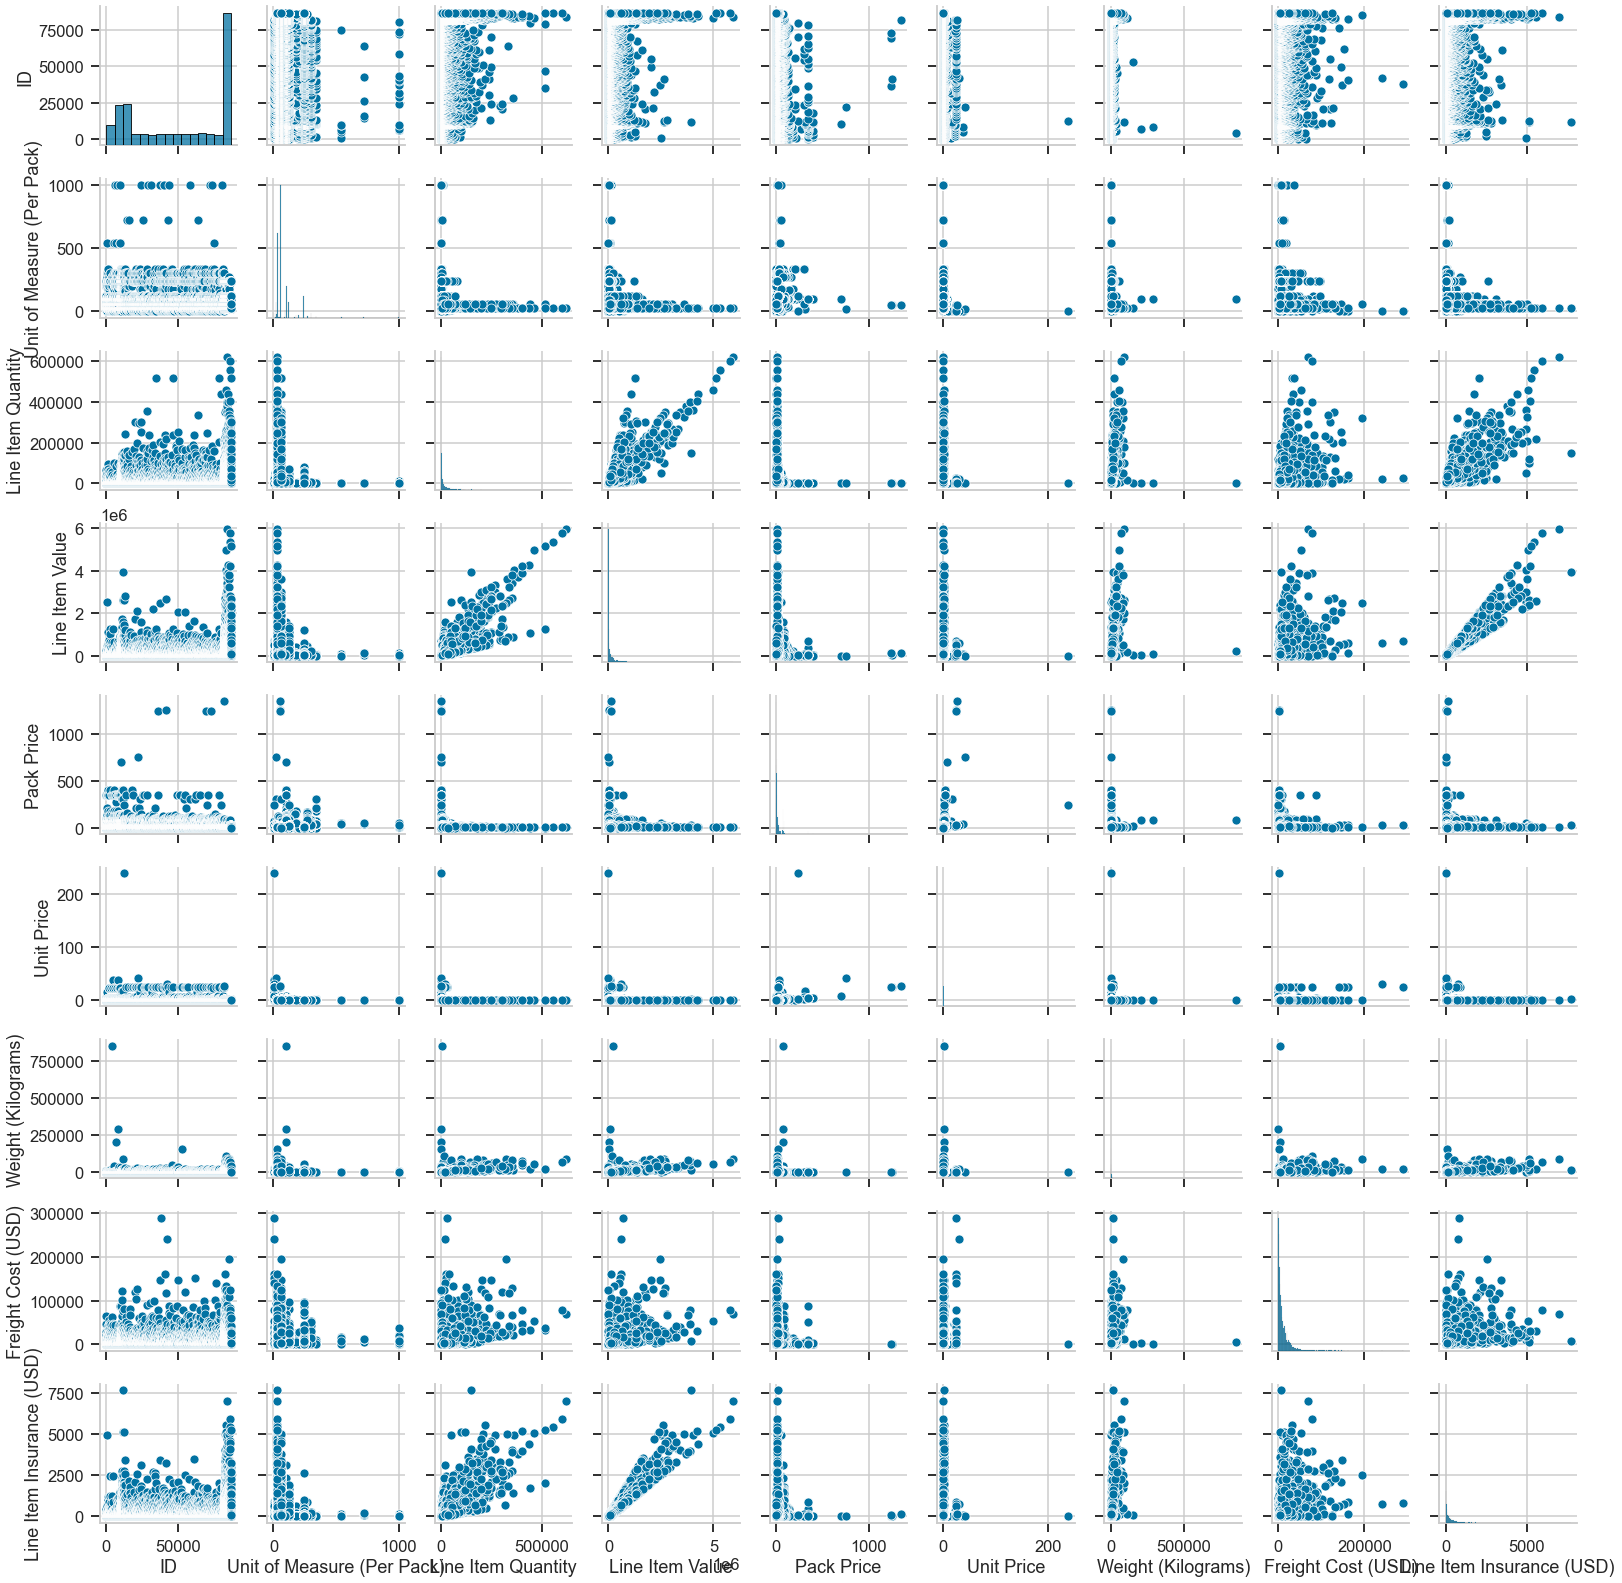

In [31]:
sns.pairplot(df[numerical_columns])

# Data Cleaning and Feature Engineering

In [32]:
df.columns

Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object')

In [33]:
df.head()

ID Project Code            PQ # PO / SO # ASN/DN #        Country  \
0   1   100-CI-T01  Pre-PQ Process    SCMS-4    ASN-8  Côte d'Ivoire   
1   3   108-VN-T01  Pre-PQ Process   SCMS-13   ASN-85        Vietnam   
2   4   100-CI-T01  Pre-PQ Process   SCMS-20   ASN-14  Côte d'Ivoire   
3  15   108-VN-T01  Pre-PQ Process   SCMS-78   ASN-50        Vietnam   
4  16   108-VN-T01  Pre-PQ Process   SCMS-81   ASN-55        Vietnam   

  Managed By  Fulfill Via Vendor INCO Term Shipment Mode  ...  \
0   PMO - US  Direct Drop              EXW           Air  ...   
1   PMO - US  Direct Drop              EXW           Air  ...   
2   PMO - US  Direct Drop              FCA           Air  ...   
3   PMO - US  Direct Drop              EXW           Air  ...   
4   PMO - US  Direct Drop              EXW           Air  ...   

  Unit of Measure (Per Pack) Line Item Quantity Line Item Value Pack Price  \
0                         30                 19           551.0      29.00   
1                        240               1000          6200.0       6.20   
2                        100                500         40000.0      80.00   
3                         60              31920        127360.8       3.99   
4                         60              38000        121600.0       3.20   

  Unit Price             Manufacturing Site First Line Designation  \
0       0.97     Ranbaxy Fine Chemicals LTD                    Yes   
1       0.03      Aurobindo Unit III, India                    Yes   
2       0.80  ABBVIE GmbH & Co.KG Wiesbaden                    Yes   
3       0.07  Ranbaxy, Paonta Shahib, India                    Yes   
4       0.05      Aurobindo Unit III, India                    Yes   

  Weight (Kilograms) Freight Cost (USD) Line Item Insurance (USD)  
0               13.0             780.34                       NaN  
1              358.0            4521.50                       NaN  
2              171.0            1653.78                       NaN  
3             1855.0           16007.06                       NaN  
4             7590.0           45450.08                       NaN  

[5 rows x 33 columns]

##### Adding a new column(lot_variety_freq) in dataframe which wil tell how many variety of products are shipped together

In [34]:
a = []
for i in df['ASN/DN #'].unique():
    count = 0
    for j in df['ASN/DN #']:
        if j == i:
            count =  count+1
    a.append([i, count])        
 

In [35]:
sorted(a, key = lambda x:x[1],reverse = True)

[['ASN-19166', 54],
 ['ASN-24415', 38],
 ['ASN-23875', 26],
 ['ASN-32138', 19],
 ['DN-304', 17],
 ['ASN-30792', 17],
 ['ASN-28034', 17],
 ['ASN-28036', 17],
 ['ASN-28033', 17],
 ['ASN-1520', 16],
 ['ASN-1665', 16],
 ['ASN-2293', 16],
 ['ASN-29764', 16],
 ['ASN-7373', 16],
 ['ASN-28037', 16],
 ['ASN-1251', 15],
 ['ASN-3732', 15],
 ['ASN-27979', 15],
 ['ASN-27978', 15],
 ['ASN-32231', 15],
 ['ASN-27980', 15],
 ['ASN-31750', 15],
 ['ASN-27976', 15],
 ['ASN-24433', 15],
 ['ASN-3553', 14],
 ['ASN-30377', 14],
 ['ASN-28279', 14],
 ['ASN-31070', 14],
 ['ASN-33852', 14],
 ['ASN-28021', 14],
 ['ASN-30671', 14],
 ['ASN-29257', 14],
 ['ASN-26882', 14],
 ['ASN-3752', 13],
 ['ASN-32122', 13],
 ['ASN-33470', 13],
 ['ASN-33851', 13],
 ['ASN-31854', 13],
 ['ASN-33865', 13],
 ['DN-3015', 13],
 ['ASN-29597', 12],
 ['ASN-33477', 12],
 ['ASN-26738', 11],
 ['ASN-32524', 11],
 ['DN-2035', 11],
 ['DN-3561', 11],
 ['ASN-2503', 10],
 ['ASN-3607', 10],
 ['DN-332', 10],
 ['ASN-24721', 10],
 ['ASN-5373', 10],
 ['

In [36]:
df['asn/dn freq'] = 0

In [37]:
for i in a:
    df['asn/dn freq'] [df['ASN/DN #']== i[0] ] = i[1]
  

In [38]:
df.head(10)

ID Project Code            PQ # PO / SO # ASN/DN #        Country  \
0   1   100-CI-T01  Pre-PQ Process    SCMS-4    ASN-8  Côte d'Ivoire   
1   3   108-VN-T01  Pre-PQ Process   SCMS-13   ASN-85        Vietnam   
2   4   100-CI-T01  Pre-PQ Process   SCMS-20   ASN-14  Côte d'Ivoire   
3  15   108-VN-T01  Pre-PQ Process   SCMS-78   ASN-50        Vietnam   
4  16   108-VN-T01  Pre-PQ Process   SCMS-81   ASN-55        Vietnam   
5  23   112-NG-T01  Pre-PQ Process   SCMS-87   ASN-57        Nigeria   
6  44   110-ZM-T01  Pre-PQ Process  SCMS-139  ASN-130         Zambia   
7  45   109-TZ-T01  Pre-PQ Process  SCMS-140   ASN-94       Tanzania   
8  46   112-NG-T01  Pre-PQ Process  SCMS-156   ASN-93        Nigeria   
9  47   110-ZM-T01  Pre-PQ Process  SCMS-165  ASN-199         Zambia   

  Managed By  Fulfill Via Vendor INCO Term Shipment Mode  ...  \
0   PMO - US  Direct Drop              EXW           Air  ...   
1   PMO - US  Direct Drop              EXW           Air  ...   
2   PMO - US  Direct Drop              FCA           Air  ...   
3   PMO - US  Direct Drop              EXW           Air  ...   
4   PMO - US  Direct Drop              EXW           Air  ...   
5   PMO - US  Direct Drop              EXW           Air  ...   
6   PMO - US  Direct Drop              DDU           Air  ...   
7   PMO - US  Direct Drop              EXW           Air  ...   
8   PMO - US  Direct Drop              EXW           Air  ...   
9   PMO - US  Direct Drop              CIP           Air  ...   

  Line Item Quantity Line Item Value Pack Price Unit Price  \
0                 19          551.00      29.00       0.97   
1               1000         6200.00       6.20       0.03   
2                500        40000.00      80.00       0.80   
3              31920       127360.80       3.99       0.07   
4              38000       121600.00       3.20       0.05   
5                416         2225.60       5.35       0.02   
6                135         4374.00      32.40       0.36   
7              16667        60834.55       3.65       0.06   
8                273          532.35       1.95       0.03   
9               2800       115080.00      41.10       0.34   

               Manufacturing Site First Line Designation Weight (Kilograms)  \
0      Ranbaxy Fine Chemicals LTD                    Yes               13.0   
1       Aurobindo Unit III, India                    Yes              358.0   
2   ABBVIE GmbH & Co.KG Wiesbaden                    Yes              171.0   
3   Ranbaxy, Paonta Shahib, India                    Yes             1855.0   
4       Aurobindo Unit III, India                    Yes             7590.0   
5       Aurobindo Unit III, India                    Yes              504.0   
6   MSD South Granville Australia                    Yes              328.0   
7       Aurobindo Unit III, India                    Yes             1478.0   
8       Aurobindo Unit III, India                     No                NaN   
9  ABBVIE (Abbott) St. P'burg USA                    Yes              643.0   

  Freight Cost (USD) Line Item Insurance (USD) asn/dn freq  
0             780.34                       NaN           1  
1            4521.50                       NaN           1  
2            1653.78                       NaN           1  
3           16007.06                       NaN           1  
4           45450.08                       NaN           3  
5            5920.42                       NaN           4  
6                NaN                       NaN           2  
7            6212.41                       NaN           1  
8                NaN                       NaN           4  
9                NaN                       NaN           1  

[10 rows x 34 columns]

In [39]:
df[df['ASN/DN #']== 'ASN-57']

ID Project Code            PQ # PO / SO # ASN/DN #  Country Managed By  \
5      23   112-NG-T01  Pre-PQ Process   SCMS-87   ASN-57  Nigeria   PMO - US   
278  2661   112-NG-T01  Pre-PQ Process   SCMS-87   ASN-57  Nigeria   PMO - US   
279  2662   112-NG-T01  Pre-PQ Process   SCMS-87   ASN-57  Nigeria   PMO - US   
525  5253   112-NG-T01  Pre-PQ Process   SCMS-87   ASN-57  Nigeria   PMO - US   

     Fulfill Via Vendor INCO Term Shipment Mode  ... Line Item Quantity  \
5    Direct Drop              EXW           Air  ...                416   
278  Direct Drop              EXW           Air  ...                416   
279  Direct Drop              EXW           Air  ...                486   
525  Direct Drop              EXW           Air  ...                416   

    Line Item Value Pack Price Unit Price         Manufacturing Site  \
5            2225.6       5.35       0.02  Aurobindo Unit III, India   
278          1809.6       4.35       0.02  Aurobindo Unit III, India   
279          2041.2       4.20       0.07  Aurobindo Unit III, India   
525          2579.2       6.20       0.03  Aurobindo Unit III, India   

    First Line Designation Weight (Kilograms) Freight Cost (USD)  \
5                      Yes              504.0            5920.42   
278                     No                NaN                NaN   
279                     No                NaN                NaN   
525                     No                NaN                NaN   

    Line Item Insurance (USD) asn/dn freq  
5                         NaN           4  
278                       NaN           4  
279                       NaN           4  
525                       NaN           4  

[4 rows x 34 columns]

In [40]:
df.drop(['ASN/DN #'], axis =1 , inplace = True)

In [41]:
df.groupby(by = df['Managed By']).count()

ID  Project Code   PQ #  PO / SO #  Country  \
Managed By                                                                  
Ethiopia Field Office          1             1      1          1        1   
Haiti Field Office             1             1      1          1        1   
PMO - US                   10265         10265  10265      10265    10265   
South Africa Field Office     57            57     57         57       57   

                           Fulfill Via  Vendor INCO Term  Shipment Mode  \
Managed By                                                                
Ethiopia Field Office                1                 1              1   
Haiti Field Office                   1                 1              1   
PMO - US                         10265             10265           9905   
South Africa Field Office           57                57             57   

                           PQ First Sent to Client Date  \
Managed By                                                
Ethiopia Field Office                                 1   
Haiti Field Office                                    1   
PMO - US                                           7584   
South Africa Field Office                            57   

                           PO Sent to Vendor Date  ...  Line Item Quantity  \
Managed By                                         ...                       
Ethiopia Field Office                           1  ...                   1   
Haiti Field Office                              1  ...                   1   
PMO - US                                     4590  ...               10265   
South Africa Field Office                       0  ...                  57   

                           Line Item Value  Pack Price  Unit Price  \
Managed By                                                           
Ethiopia Field Office                    1           1           1   
Haiti Field Office                       1           1           1   
PMO - US                             10265       10265       10265   
South Africa Field Office               57          57          57   

                           Manufacturing Site  First Line Designation  \
Managed By                                                              
Ethiopia Field Office                       1                       1   
Haiti Field Office                          1                       1   
PMO - US                                10265                   10265   
South Africa Field Office                  57                      57   

                           Weight (Kilograms)  Freight Cost (USD)  \
Managed By                                                          
Ethiopia Field Office                       0                   0   
Haiti Field Office                          1                   1   
PMO - US                                 6371                6197   
South Africa Field Office                   0                   0   

                           Line Item Insurance (USD)  asn/dn freq  
Managed By                                                         
Ethiopia Field Office                              1            1  
Haiti Field Office                                 1            1  
PMO - US                                        9978        10265  
South Africa Field Office                         57           57  

[4 rows x 32 columns]

In [42]:
df.columns

Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'Country', 'Managed By',
       'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)', 'asn/dn freq'],
      dtype='object')

In [43]:
df.drop(['PQ First Sent to Client Date'], axis =1 , inplace = True)

In [44]:
df[df['PO Sent to Vendor Date'] == 'Date Not Captured'].shape

(0, 32)

In [45]:
df.drop(df[df['PO Sent to Vendor Date']=='N/A - From RDC'].index, inplace = True)

In [46]:
df['PO Sent to Vendor Date']= pd.to_datetime(df['PO Sent to Vendor Date'])

In [47]:
df['Scheduled Delivery Date']= pd.to_datetime(df['Scheduled Delivery Date'])

In [48]:
df['Scheduled Delivery Date'] = pd.to_datetime(df['Scheduled Delivery Date'])

In [49]:
df['delayed'] = 0

In [50]:
df['is_delay'] = np.where(df['Delivered to Client Date']>df['Scheduled Delivery Date'], 1, 0)
df.head()

ID Project Code            PQ # PO / SO #        Country Managed By  \
0   1   100-CI-T01  Pre-PQ Process    SCMS-4  Côte d'Ivoire   PMO - US   
1   3   108-VN-T01  Pre-PQ Process   SCMS-13        Vietnam   PMO - US   
2   4   100-CI-T01  Pre-PQ Process   SCMS-20  Côte d'Ivoire   PMO - US   
3  15   108-VN-T01  Pre-PQ Process   SCMS-78        Vietnam   PMO - US   
4  16   108-VN-T01  Pre-PQ Process   SCMS-81        Vietnam   PMO - US   

   Fulfill Via Vendor INCO Term Shipment Mode PO Sent to Vendor Date  ...  \
0  Direct Drop              EXW           Air                    NaT  ...   
1  Direct Drop              EXW           Air                    NaT  ...   
2  Direct Drop              FCA           Air                    NaT  ...   
3  Direct Drop              EXW           Air                    NaT  ...   
4  Direct Drop              EXW           Air                    NaT  ...   

  Pack Price Unit Price             Manufacturing Site First Line Designation  \
0      29.00       0.97     Ranbaxy Fine Chemicals LTD                    Yes   
1       6.20       0.03      Aurobindo Unit III, India                    Yes   
2      80.00       0.80  ABBVIE GmbH & Co.KG Wiesbaden                    Yes   
3       3.99       0.07  Ranbaxy, Paonta Shahib, India                    Yes   
4       3.20       0.05      Aurobindo Unit III, India                    Yes   

  Weight (Kilograms) Freight Cost (USD) Line Item Insurance (USD) asn/dn freq  \
0               13.0             780.34                       NaN           1   
1              358.0            4521.50                       NaN           1   
2              171.0            1653.78                       NaN           1   
3             1855.0           16007.06                       NaN           1   
4             7590.0           45450.08                       NaN           3   

  delayed is_delay  
0       0        0  
1       0        0  
2       0        0  
3       0        0  
4       0        0  

[5 rows x 34 columns]

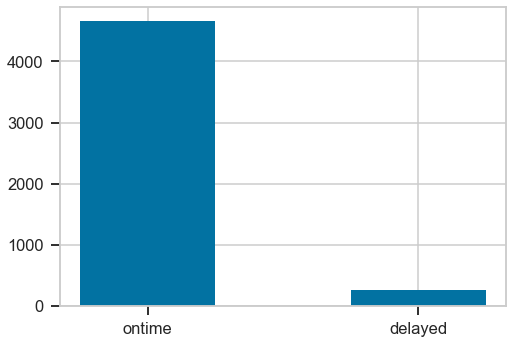

In [51]:
plt.bar(['ontime', 'delayed'],[4661, 259], width = 0.5)
plt.show()

In [52]:

#Removing error in data
df.drop(df[df['PO Sent to Vendor Date'] >df['Delivered to Client Date' ]].index, inplace = True)


In [53]:
df['lead_time'] = df['Delivered to Client Date'] - df['PO Sent to Vendor Date']
df['lead_time'] = df['lead_time'] /np.timedelta64(1,'D')

In [54]:
df.head()

ID Project Code            PQ # PO / SO #        Country Managed By  \
0   1   100-CI-T01  Pre-PQ Process    SCMS-4  Côte d'Ivoire   PMO - US   
1   3   108-VN-T01  Pre-PQ Process   SCMS-13        Vietnam   PMO - US   
2   4   100-CI-T01  Pre-PQ Process   SCMS-20  Côte d'Ivoire   PMO - US   
3  15   108-VN-T01  Pre-PQ Process   SCMS-78        Vietnam   PMO - US   
4  16   108-VN-T01  Pre-PQ Process   SCMS-81        Vietnam   PMO - US   

   Fulfill Via Vendor INCO Term Shipment Mode PO Sent to Vendor Date  ...  \
0  Direct Drop              EXW           Air                    NaT  ...   
1  Direct Drop              EXW           Air                    NaT  ...   
2  Direct Drop              FCA           Air                    NaT  ...   
3  Direct Drop              EXW           Air                    NaT  ...   
4  Direct Drop              EXW           Air                    NaT  ...   

  Unit Price             Manufacturing Site First Line Designation  \
0       0.97     Ranbaxy Fine Chemicals LTD                    Yes   
1       0.03      Aurobindo Unit III, India                    Yes   
2       0.80  ABBVIE GmbH & Co.KG Wiesbaden                    Yes   
3       0.07  Ranbaxy, Paonta Shahib, India                    Yes   
4       0.05      Aurobindo Unit III, India                    Yes   

  Weight (Kilograms) Freight Cost (USD) Line Item Insurance (USD) asn/dn freq  \
0               13.0             780.34                       NaN           1   
1              358.0            4521.50                       NaN           1   
2              171.0            1653.78                       NaN           1   
3             1855.0           16007.06                       NaN           1   
4             7590.0           45450.08                       NaN           3   

  delayed is_delay lead_time  
0       0        0       NaN  
1       0        0       NaN  
2       0        0       NaN  
3       0        0       NaN  
4       0        0       NaN  

[5 rows x 35 columns]

In [55]:
df['lead_time'].replace(np.nan, df['lead_time'].median(), inplace = True)

In [56]:
df.head()

ID Project Code            PQ # PO / SO #        Country Managed By  \
0   1   100-CI-T01  Pre-PQ Process    SCMS-4  Côte d'Ivoire   PMO - US   
1   3   108-VN-T01  Pre-PQ Process   SCMS-13        Vietnam   PMO - US   
2   4   100-CI-T01  Pre-PQ Process   SCMS-20  Côte d'Ivoire   PMO - US   
3  15   108-VN-T01  Pre-PQ Process   SCMS-78        Vietnam   PMO - US   
4  16   108-VN-T01  Pre-PQ Process   SCMS-81        Vietnam   PMO - US   

   Fulfill Via Vendor INCO Term Shipment Mode PO Sent to Vendor Date  ...  \
0  Direct Drop              EXW           Air                    NaT  ...   
1  Direct Drop              EXW           Air                    NaT  ...   
2  Direct Drop              FCA           Air                    NaT  ...   
3  Direct Drop              EXW           Air                    NaT  ...   
4  Direct Drop              EXW           Air                    NaT  ...   

  Unit Price             Manufacturing Site First Line Designation  \
0       0.97     Ranbaxy Fine Chemicals LTD                    Yes   
1       0.03      Aurobindo Unit III, India                    Yes   
2       0.80  ABBVIE GmbH & Co.KG Wiesbaden                    Yes   
3       0.07  Ranbaxy, Paonta Shahib, India                    Yes   
4       0.05      Aurobindo Unit III, India                    Yes   

  Weight (Kilograms) Freight Cost (USD) Line Item Insurance (USD) asn/dn freq  \
0               13.0             780.34                       NaN           1   
1              358.0            4521.50                       NaN           1   
2              171.0            1653.78                       NaN           1   
3             1855.0           16007.06                       NaN           1   
4             7590.0           45450.08                       NaN           3   

  delayed is_delay lead_time  
0       0        0      92.0  
1       0        0      92.0  
2       0        0      92.0  
3       0        0      92.0  
4       0        0      92.0  

[5 rows x 35 columns]

In [57]:
df.drop('Delivery Recorded Date', axis =1 , inplace =True)

In [58]:
df.columns

Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'Country', 'Managed By',
       'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PO Sent to Vendor Date', 'Scheduled Delivery Date',
       'Delivered to Client Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)', 'asn/dn freq', 'delayed', 'is_delay',
       'lead_time'],
      dtype='object')

### **Changing the data types of the certain columns. Also dropping the low-importance variables which wont contribute much in the modelling**

In [59]:
df.drop('Brand',axis=1, inplace = True)

In [60]:
df.drop('Dosage',axis=1,inplace =True)

In [61]:
df.drop('Dosage Form',axis=1, inplace = True)

In [62]:
df['Line Item Quantity'] = df['Line Item Quantity'].replace(',', '')
df['Line Item Quantity'] = df['Line Item Quantity'].astype(int)

In [63]:
df['Total Units Shipped'] =   df['Line Item Quantity'] * df['Unit of Measure (Per Pack)']

In [64]:
df.drop(['Line Item Quantity','Unit of Measure (Per Pack)'], axis=1,inplace =True)

In [65]:
df['Line Item Value'] =  df['Line Item Value'].replace(',', '')

In [66]:
df['Line Item Value']  = df['Line Item Value'].astype(float)

In [67]:
df.drop('Pack Price', axis =1, inplace =True)

In [68]:
df.drop('Manufacturing Site', axis =1, inplace =True)

In [69]:
df.drop('First Line Designation', axis=1, inplace =True)

In [70]:
df.drop(['Item Description'], axis =1, inplace =True)

In [71]:
df.drop('Fulfill Via', axis =1, inplace =True)

In [72]:
df.drop(['Project Code','Managed By','Scheduled Delivery Date'], axis =1, inplace = True)

In [73]:
df['Year'] = pd.DatetimeIndex(df['Delivered to Client Date']).year

In [74]:
df.drop('Delivered to Client Date', axis =1, inplace =True)

In [75]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [76]:
df_new = df

In [77]:
df_new.isnull().sum()

ID                              0
PQ #                            0
PO / SO #                       0
Country                         0
Vendor INCO Term                0
Shipment Mode                 359
PO Sent to Vendor Date       5732
Product Group                   0
Sub Classification              0
Vendor                          0
Molecule/Test Type              0
Line Item Value                 0
Unit Price                      0
Weight (Kilograms)           3947
Freight Cost (USD)           4121
Line Item Insurance (USD)     287
asn/dn freq                     0
delayed                         0
is_delay                        0
lead_time                       0
Total Units Shipped             0
Year                            0
dtype: int64

In [78]:
df['Shipment Mode'].fillna('other', inplace =  True)

In [79]:
def is_float(x):
    # if try don't work it won't give error if try statement don't work
    try:
        return float(x)
    except:
        return np.nan

In [80]:
df_new['Weight (Kilograms)']=df_new['Weight (Kilograms)'].apply(is_float)


In [81]:
df_new['Weight (Kilograms)'] =  df_new['Weight (Kilograms)']*df_new['Total Units Shipped']

In [82]:
df_new['Freight Cost (USD)'].fillna(value=df_new['Freight Cost (USD)'].mean(), inplace=True)

In [83]:
df_new['Weight (Kilograms)'].fillna(value=df_new['Weight (Kilograms)'].mean(), inplace=True)

In [84]:
df_new.columns

Index(['ID', 'PQ #', 'PO / SO #', 'Country', 'Vendor INCO Term',
       'Shipment Mode', 'PO Sent to Vendor Date', 'Product Group',
       'Sub Classification', 'Vendor', 'Molecule/Test Type', 'Line Item Value',
       'Unit Price', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)', 'asn/dn freq', 'delayed', 'is_delay',
       'lead_time', 'Total Units Shipped', 'Year'],
      dtype='object')

In [85]:
df_new.drop(['ID','PQ #','PO / SO #','PO Sent to Vendor Date',
        'Line Item Insurance (USD)','delayed'], 
        axis =1, inplace =True)

In [86]:
from sklearn.preprocessing import LabelEncoder

In [87]:
df_new.head()

Country Vendor INCO Term Shipment Mode Product Group  \
0  Côte d'Ivoire              EXW           Air          HRDT   
1        Vietnam              EXW           Air           ARV   
2  Côte d'Ivoire              FCA           Air          HRDT   
3        Vietnam              EXW           Air           ARV   
4        Vietnam              EXW           Air           ARV   

  Sub Classification                                             Vendor  \
0           HIV test                        RANBAXY Fine Chemicals LTD.   
1          Pediatric                           Aurobindo Pharma Limited   
2           HIV test                               Abbott GmbH & Co. KG   
3              Adult  SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...   
4              Adult                           Aurobindo Pharma Limited   

                         Molecule/Test Type  Line Item Value  Unit Price  \
0  HIV, Reveal G3 Rapid HIV-1 Antibody Test            551.0        0.97   
1                                Nevirapine           6200.0        0.03   
2       HIV 1/2, Determine Complete HIV Kit          40000.0        0.80   
3                                Lamivudine         127360.8        0.07   
4                                 Stavudine         121600.0        0.05   

   Weight (Kilograms)  Freight Cost (USD)  asn/dn freq  is_delay  lead_time  \
0        7.410000e+03              780.34            1         0       92.0   
1        8.592000e+07             4521.50            1         0       92.0   
2        8.550000e+06             1653.78            1         0       92.0   
3        3.552696e+09            16007.06            1         0       92.0   
4        1.730520e+10            45450.08            3         0       92.0   

   Total Units Shipped  Year  
0                  570  2006  
1               240000  2006  
2                50000  2006  
3              1915200  2006  
4              2280000  2006

In [88]:
X = df_new.drop(['is_delay'], axis=1)
Y = df_new['is_delay']
X.head()

Country Vendor INCO Term Shipment Mode Product Group  \
0  Côte d'Ivoire              EXW           Air          HRDT   
1        Vietnam              EXW           Air           ARV   
2  Côte d'Ivoire              FCA           Air          HRDT   
3        Vietnam              EXW           Air           ARV   
4        Vietnam              EXW           Air           ARV   

  Sub Classification                                             Vendor  \
0           HIV test                        RANBAXY Fine Chemicals LTD.   
1          Pediatric                           Aurobindo Pharma Limited   
2           HIV test                               Abbott GmbH & Co. KG   
3              Adult  SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...   
4              Adult                           Aurobindo Pharma Limited   

                         Molecule/Test Type  Line Item Value  Unit Price  \
0  HIV, Reveal G3 Rapid HIV-1 Antibody Test            551.0        0.97   
1                                Nevirapine           6200.0        0.03   
2       HIV 1/2, Determine Complete HIV Kit          40000.0        0.80   
3                                Lamivudine         127360.8        0.07   
4                                 Stavudine         121600.0        0.05   

   Weight (Kilograms)  Freight Cost (USD)  asn/dn freq  lead_time  \
0        7.410000e+03              780.34            1       92.0   
1        8.592000e+07             4521.50            1       92.0   
2        8.550000e+06             1653.78            1       92.0   
3        3.552696e+09            16007.06            1       92.0   
4        1.730520e+10            45450.08            3       92.0   

   Total Units Shipped  Year  
0                  570  2006  
1               240000  2006  
2                50000  2006  
3              1915200  2006  
4              2280000  2006

In [89]:
enc = LabelEncoder()
X.loc[:,['Country', 'Vendor INCO Term', 'Shipment Mode', 'Product Group', 'Sub Classification','Vendor', 'Molecule/Test Type']] = X.loc[:,['Country', 'Vendor INCO Term', 'Shipment Mode', 'Product Group', 'Sub Classification','Vendor', 'Molecule/Test Type']].apply(enc.fit_transform)


In [90]:
X.head()

Country  Vendor INCO Term  Shipment Mode  Product Group  \
0        9                 5              0              3   
1       40                 5              0              2   
2        9                 6              0              3   
3       40                 5              0              2   
4       40                 5              0              2   

   Sub Classification  Vendor  Molecule/Test Type  Line Item Value  \
0                   2      56                  55            551.0   
1                   5      13                  74           6200.0   
2                   2      12                  27          40000.0   
3                   1      64                  57         127360.8   
4                   1      13                  82         121600.0   

   Unit Price  Weight (Kilograms)  Freight Cost (USD)  asn/dn freq  lead_time  \
0        0.97        7.410000e+03              780.34            1       92.0   
1        0.03        8.592000e+07             4521.50            1       92.0   
2        0.80        8.550000e+06             1653.78            1       92.0   
3        0.07        3.552696e+09            16007.06            1       92.0   
4        0.05        1.730520e+10            45450.08            3       92.0   

   Total Units Shipped  Year  
0                  570  2006  
1               240000  2006  
2                50000  2006  
3              1915200  2006  
4              2280000  2006

In [91]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [92]:
X[[ 'Molecule/Test Type','Line Item Value','Unit Price','Weight (Kilograms)',
   
   'Freight Cost (USD)','asn/dn freq','lead_time','Total Units Shipped','Year' ]] = scaler.fit_transform(X[[  

'Molecule/Test Type','Line Item Value','Unit Price','Weight (Kilograms)',
   
   'Freight Cost (USD)','asn/dn freq','lead_time','Total Units Shipped','Year' 

]])

In [93]:
X.head()

Country  Vendor INCO Term  Shipment Mode  Product Group  \
0        9                 5              0              3   
1       40                 5              0              2   
2        9                 6              0              3   
3       40                 5              0              2   
4       40                 5              0              2   

   Sub Classification  Vendor  Molecule/Test Type  Line Item Value  \
0                   2      56            0.330959        -0.455083   
1                   5      13            1.022943        -0.438726   
2                   2      12           -0.688808        -0.340853   
3                   1      64            0.403799        -0.087886   
4                   1      13            1.314305        -0.104567   

   Unit Price  Weight (Kilograms)  Freight Cost (USD)  asn/dn freq  lead_time  \
0    0.109304           -0.250269           -0.842393    -0.408092   -0.11508   
1   -0.177594           -0.248689           -0.537098    -0.408092   -0.11508   
2    0.057418           -0.250112           -0.771116    -0.408092   -0.11508   
3   -0.165386           -0.184910            0.400173    -0.408092   -0.11508   
4   -0.171490            0.068096            2.802850    -0.051973   -0.11508   

   Total Units Shipped     Year  
0            -0.474711 -2.10813  
1            -0.357127 -2.10813  
2            -0.450436 -2.10813  
3             0.465566 -2.10813  
4             0.644720 -2.10813

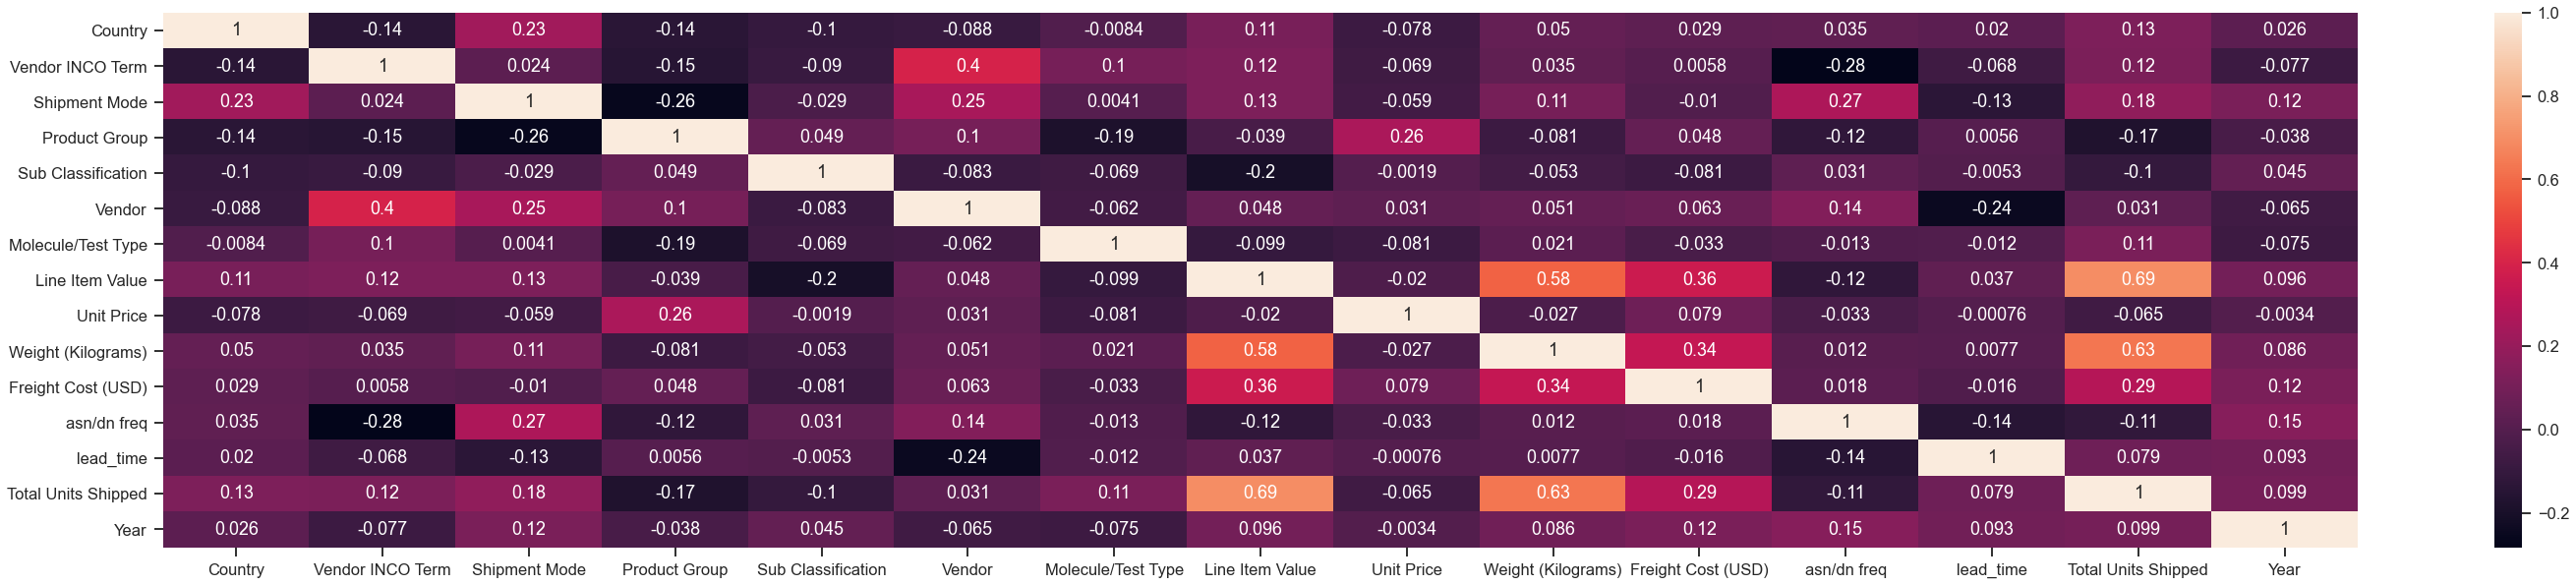

In [94]:
plt.figure(figsize=(50,10))
           
corrMatrix = X.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [95]:
#Splitting the data in train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 123)

In [96]:
def visual_model_selection(X_train, X_test, y_train, y_test, estimator, show_plot=True):
    """
    Takes train and test data sets for both features and target plus an estimator and 
    returns a visual classification report.
    """ 
    from sklearn.pipeline import Pipeline 
    from yellowbrick.classifier import ClassificationReport
    #y_train = preprocessing.LabelEncoder().fit_transform(y_train.values.ravel())
    #y_test = preprocessing.LabelEncoder().fit_transform(y_test.values.ravel())
        
    model = Pipeline([('estimator', estimator)])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(model, classes=['on-time', 'delayed'])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()

In [97]:
def train_test_oversample(X, y, test_size=0.20, use_smote=False):
    """
    Returns oversampled X and y dataframes depending on key word args.
    """
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    # Train-Test split
    X_tr_clf_res, X_ts_clf_res, y_tr_clf_res, y_ts_clf_res = train_test_split(
            X,y,test_size=test_size, random_state=121)

    smote = SMOTE(random_state=121)
    print("XTrain, yTrain shapes BEFORE Oversampling: {} and {}".format(X_tr_clf_res.shape, y_tr_clf_res.shape))
    if use_smote: # do oversample technique
        X_tr_clf_res, y_tr_clf_res = smote.fit_resample(X_tr_clf_res, y_tr_clf_res)
    print("XTrain, yTrain shapes AFTER Oversampling: {} and {}".format(X_tr_clf_res.shape, y_tr_clf_res.shape))
    # Convert to dataframes for helper formulae
    X_tr_clf_res = pd.DataFrame(X_tr_clf_res, columns=X.columns)
    y_tr_clf_res = pd.DataFrame(y_tr_clf_res, columns=y)
    print("Shape of XTrain: {} yTrain: {} XTest: {} yTest: {}".format(
        X_tr_clf_res.shape, X_ts_clf_res.shape, y_tr_clf_res.shape, y_ts_clf_res.shape))
    return X_tr_clf_res, X_ts_clf_res, y_tr_clf_res, y_ts_clf_res


In [98]:
# Extract feature importances into a df
def plot_feature_importances(fitted_estimator, X_train, n_features, show_plot=True):
    """
    Takes in an estimator RFClassifier which has already been "fitted" with feature importances, the full data
    Plots the top n_features importance. Returns full dataframe of importances by feature, and importance from n_features
    """
    features_clf = X_train.columns
    key_features_clf = pd.DataFrame(fitted_estimator.feature_importances_, features_clf)
    key_features_clf.reset_index(inplace=True)
    key_features_clf.columns=['feature', 'importance']
    dfresult = key_features_clf.set_index('feature').sort_values('importance', ascending=False)[:n_features]
    print("Total Importance of {} features: {}".format(n_features,dfresult.sum()))
    if show_plot:
        dfresult.plot(kind="barh", ylim=(0,0.5))
    return key_features_clf.set_index('feature').sort_values('importance', ascending=False)


### Modelling using RandomForest Classifier

Total Importance of 30 features: importance    1.0
dtype: float64


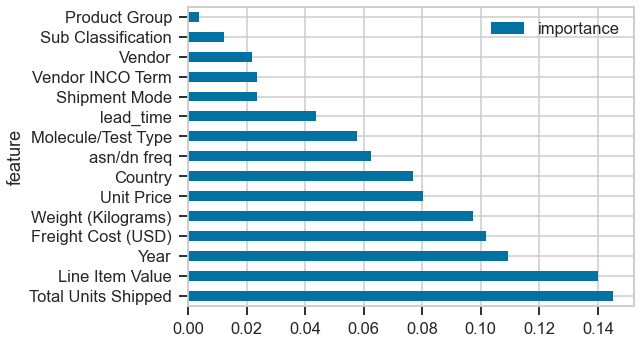

In [99]:
# Fit the regression to the data and train
clf = RandomForestClassifier(random_state=123)
clf.fit(X_train, y_train)
d_feat_imp_clf = plot_feature_importances(clf, X_train, 30)

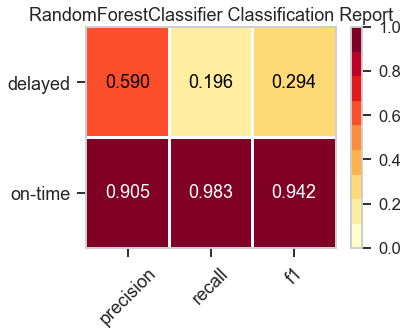

In [100]:
plt.subplots(figsize=(6,5))
y_predict = clf.predict(X_test)
visual_model_selection(X_train, X_test, y_train, y_test, clf)

In [101]:
def model_selection(X_train, X_test, y_train, y_test, estimator, alg_type):
    """
    Takes train and test data sets for both features and target plus an estimator and 
    returns f1_score or a tuple of r2 and RMSE. So be careful which alg_type you want.
    """
    # Scoring functions and some estimator built in container
    from sklearn.metrics import f1_score, r2_score, mean_squared_error
    from sklearn.pipeline import Pipeline#, preprocessing
    from sklearn import preprocessing
    import numpy as np

    model = Pipeline([ #('label_encoding', EncodeCategorical(X.keys())),
         #('one_hot_encoder', OneHotEncoder()),
         ('estimator', estimator)])    
    if alg_type == 'clf':
        # Instantiate the classification model and visualizer
        y_train = preprocessing.LabelEncoder().fit_transform(y_train.values.ravel())
        y_test = preprocessing.LabelEncoder().fit_transform(y_test.values.ravel())
        model.fit(X_train, y_train)
        expected  = y_test
        predicted = model.predict(X_test)
        # Compute and return the F1 score (the harmonic mean of precision and recall)
        return (f1_score(expected, predicted))

<AxesSubplot:title={'center':'F1 Score Comparison for Classifiers'}>

<Figure size 3600x720 with 0 Axes>

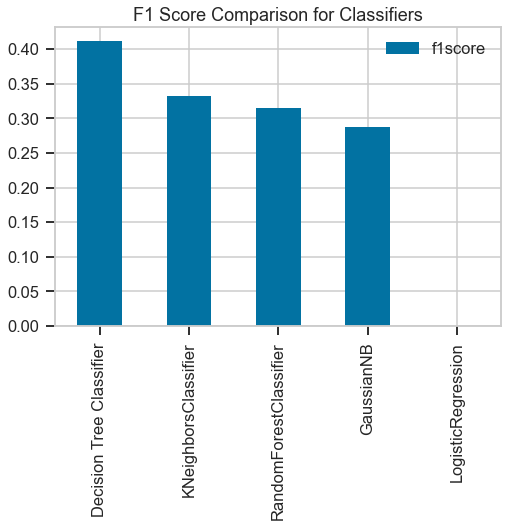

In [102]:
# Train test split custom function with OverSampling to balance datasets if required
# List of classifiers
clfs = [ KNeighborsClassifier, LogisticRegression, RandomForestClassifier, GaussianNB,DecisionTreeClassifier]
# List of classiffier names
cn = ['KNeighborsClassifier', 'LogisticRegression', 'RandomForestClassifier', 'GaussianNB', 'Decision Tree Classifier']   
# Plot the f1 scores
acc = []
for clf in clfs:
    try:
        acc.append(model_selection(X_train, X_test, y_train, y_test
                                       , clf(), 'clf'))
    except:
        acc.append(0)
d_acc = pd.DataFrame(acc, cn)
d_acc.columns = ["f1score"]
plt.figure(figsize=(50,10))
d_acc.sort_values(by ='f1score',ascending=False).plot(kind="bar", title="F1 Score Comparison for Classifiers")

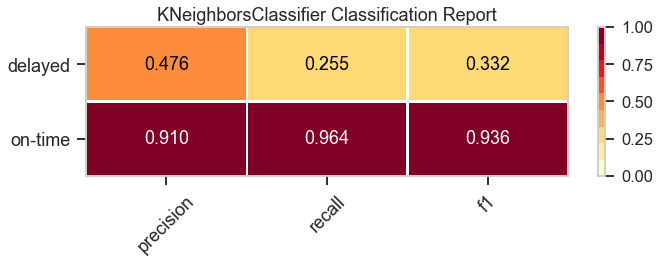

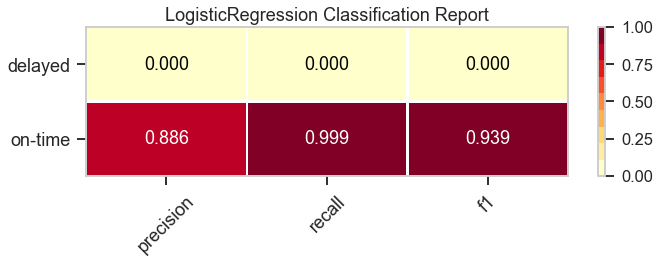

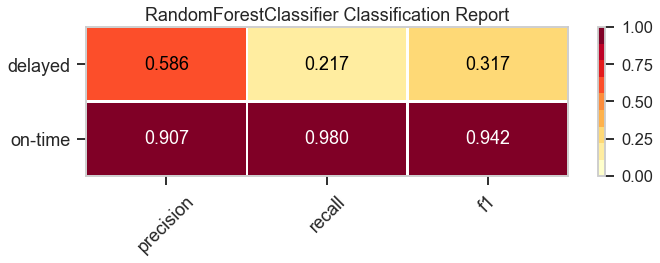

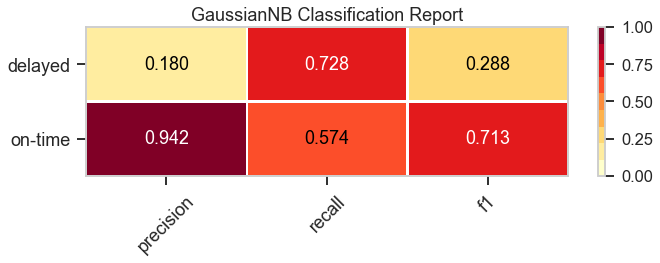

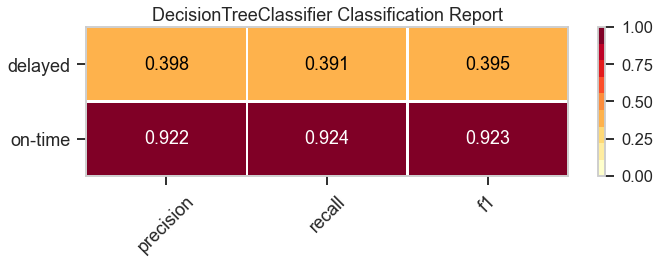

In [103]:
# Plot the classification reports
for clf in clfs:
    plt.subplots(figsize=(10,4))
    i=clfs.index(clf)
    visual_model_selection(X_train, X_test, y_train, y_test, clfs[i]())